# Partie analyse de données

In [46]:
# Functions imports

import tqdm as notebook_tqdm

# Data Management

import importlib
import functions
from dateutil import tz
import pandas as pd
from scipy import stats

# Transformation des variables

from sklearn.preprocessing import StandardScaler

# Machine Learning

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

# Functions' imports

importlib.reload(functions)
from functions import *

# Displaying options 

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Ajout des fichiers


In [47]:
x = pd.read_csv("../data/raw/X_train_Wwou3IE.csv")  # 10605 rows × 10 columns
x_challenge = pd.read_csv("../data/raw/X_test_GgyECq8.csv")  # 4942 rows × 10 columns
y = pd.read_csv("../data/raw/y_train_jJtXgMX.csv")  # 10605 rows × 2 columns

# Analyse de 'DELIVERY_START'

In [48]:
# Comme y'a beaucoup d'information contenue dans la colonne 'DELIVERY_START', nous créons
# plusieurs colonnes permettant de prendre toutes ces informations en compte

# FAIRE RUN ALL SUR CETTE CELLE LÀ À CHAQUES FOIS SINON ÇA FAIT DES ERREURS


# Extraction des caractéristiques temporelles
def add_time_features(
    df: pd.DataFrame, time_column: str
):  # Je fais une fonction car il y a plusieurs DataFrame

    df[time_column] = pd.to_datetime(
        df[time_column], errors="coerce", utc=True
    )  # Important pour pouvoir utiliser .dt
    if df[time_column].isnull().any():
        print(
            f"Warning: Some dates in column '{time_column}' could not be converted and are set to NaT"
        )

    # Gros problème, au niveau des changements d'heure, au lieu d'avoir '+1' dans DELIVERY_START
    # on a '+2' et pyhton comprend plus que c'est un date et fait crasher la fonction
    # En cherchant sur internet, j'ai trouvé qu'il fallait rajouté 'utc' dans l'argument de la fonction
    # datetime. Je rajoute une ligne pour faire une conversion en fuseau horaire local.

    # df[time_column] = df[time_column].dt.tz_convert('Europe/Paris') # Pas forcément utile

    df["hour"] = df[time_column].dt.hour
    df["day_of_week"] = df[time_column].dt.dayofweek
    df["day_of_month"] = df[time_column].dt.day
    df["month"] = df[time_column].dt.month
    df["is_weekend"] = df[time_column].dt.dayofweek > 5
    df["is_peak_hour"] = df[time_column].dt.hour.isin(range(7, 19))

    df["is_weekend"] = df["is_weekend"].astype(int)  # Pour avoir des 1/0 et pas un Boolean
    df["is_peak_hour"] = df["is_peak_hour"].astype(int)

    return df


# Appliquer les transformations sur x et x_challenge
x = add_time_features(x, "DELIVERY_START")
x_challenge = add_time_features(x_challenge, "DELIVERY_START")

x.head(1)
# x_challenge.head(1)

DELIVERY_START  load_forecast  coal_power_available  \
0 2022-01-01 01:00:00+00:00        49439.0                3386.0   

   gas_power_available  nuclear_power_available  wind_power_forecasts_average  \
0              11487.0                  44118.0                        3035.0   

   solar_power_forecasts_average  wind_power_forecasts_std  \
0                            0.0                 79.248348   

   solar_power_forecasts_std  predicted_spot_price  hour  day_of_week  \
0                        0.0                   NaN     1            5   

   day_of_month  month  is_weekend  is_peak_hour  
0             1      1           0             0

In [49]:
spot_columns(x)

Column 'DELIVERY_START' : 0 NaN values
Column 'load_forecast' : 1287 NaN values
Column 'coal_power_available' : 1 NaN values
Column 'gas_power_available' : 1 NaN values
Column 'nuclear_power_available' : 1 NaN values
Column 'wind_power_forecasts_average' : 24 NaN values
Column 'solar_power_forecasts_average' : 24 NaN values
Column 'wind_power_forecasts_std' : 24 NaN values
Column 'solar_power_forecasts_std' : 24 NaN values
Column 'predicted_spot_price' : 8759 NaN values
Column 'hour' : 0 NaN values
Column 'day_of_week' : 0 NaN values
Column 'day_of_month' : 0 NaN values
Column 'month' : 0 NaN values
Column 'is_weekend' : 0 NaN values
Column 'is_peak_hour' : 0 NaN values


In [50]:
spot_columns(x_challenge)

Column 'DELIVERY_START' : 0 NaN values
Column 'load_forecast' : 0 NaN values
Column 'coal_power_available' : 0 NaN values
Column 'gas_power_available' : 0 NaN values
Column 'nuclear_power_available' : 0 NaN values
Column 'wind_power_forecasts_average' : 0 NaN values
Column 'solar_power_forecasts_average' : 24 NaN values
Column 'wind_power_forecasts_std' : 0 NaN values
Column 'solar_power_forecasts_std' : 24 NaN values
Column 'predicted_spot_price' : 1536 NaN values
Column 'hour' : 0 NaN values
Column 'day_of_week' : 0 NaN values
Column 'day_of_month' : 0 NaN values
Column 'month' : 0 NaN values
Column 'is_weekend' : 0 NaN values
Column 'is_peak_hour' : 0 NaN values


/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() ins

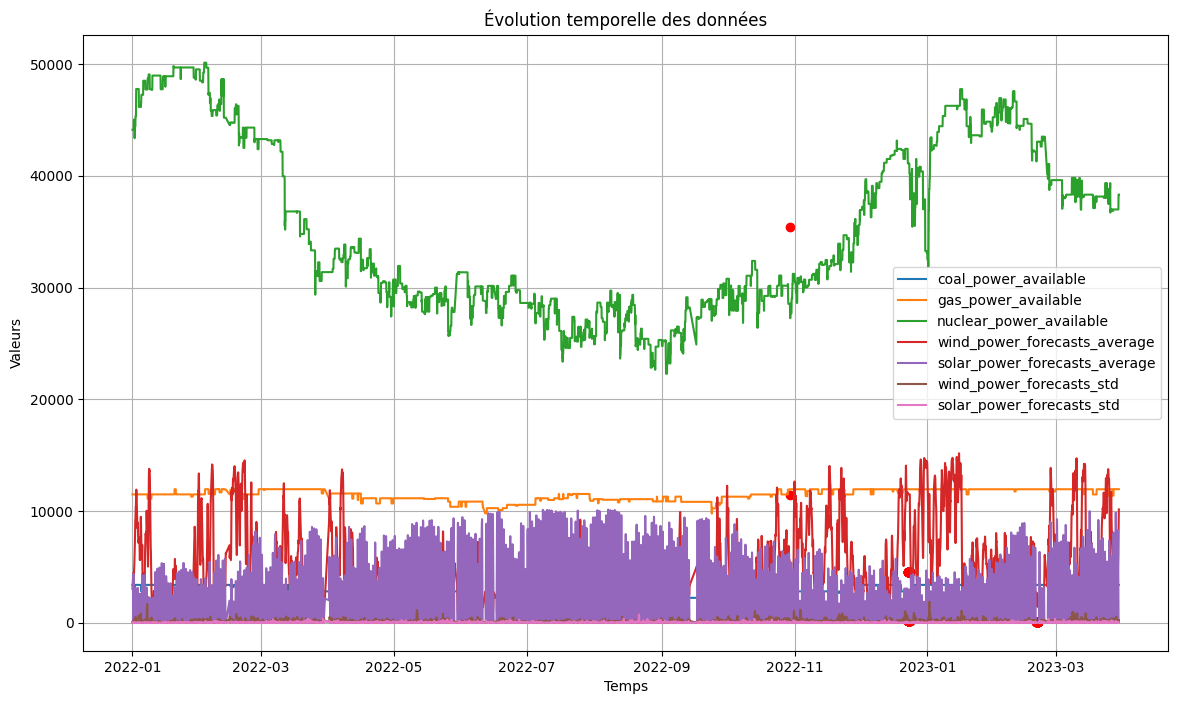

In [51]:
# On va régarder l'évolution temporelle des données pour décider comment fillna 

cols_to_plot = [
    # 'load_forecast', 
    'coal_power_available', 'gas_power_available', 'nuclear_power_available',
    'wind_power_forecasts_average', 'solar_power_forecasts_average',
    'wind_power_forecasts_std', 'solar_power_forecasts_std',
    #'predicted_spot_price'
]

plot_time_series_with_nans(x, 'DELIVERY_START', cols_to_plot, 'ffill')

# Je fais 'ffill' pour celle là parce que y'en a très peu et que les variables sont très fortements 
# dépendantes du temps 

/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)
/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() ins

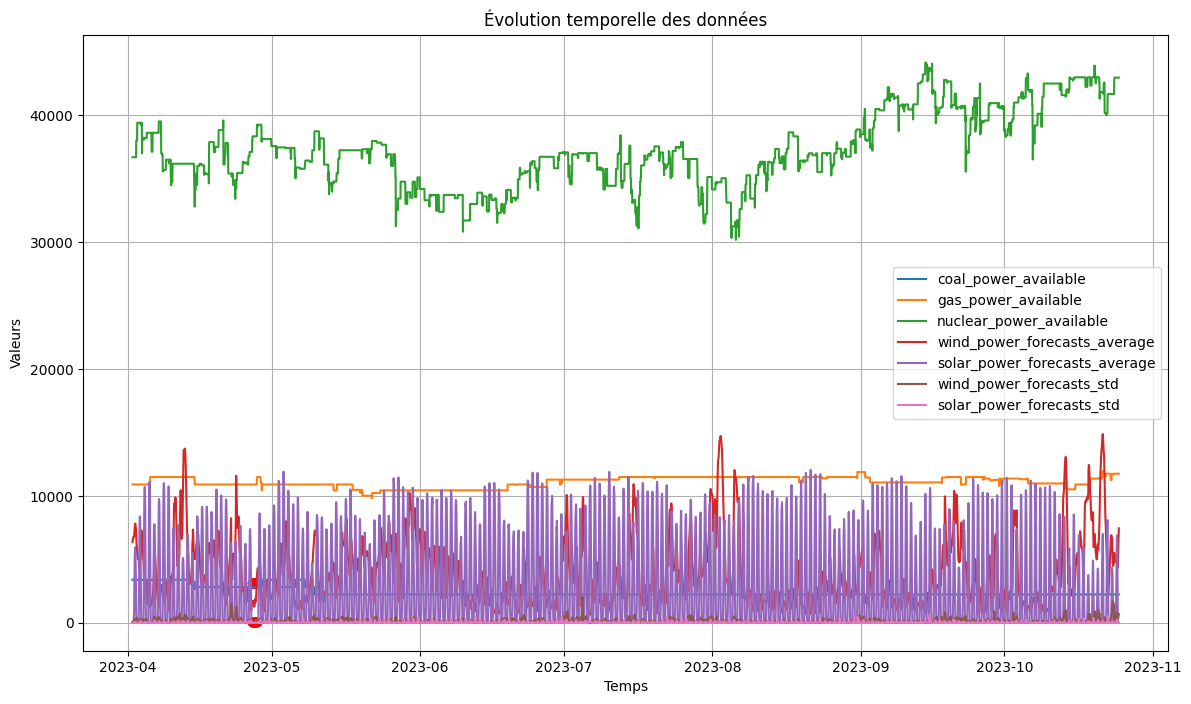

In [52]:
plot_time_series_with_nans(x_challenge, 'DELIVERY_START', cols_to_plot, 'ffill')

In [53]:
spot_columns(x)

# Il reste à s'occuper de 'load_forecast' et 'predicted_spot_price'

Column 'DELIVERY_START' : 0 NaN values
Column 'load_forecast' : 1287 NaN values
Column 'coal_power_available' : 0 NaN values
Column 'gas_power_available' : 0 NaN values
Column 'nuclear_power_available' : 0 NaN values
Column 'wind_power_forecasts_average' : 0 NaN values
Column 'solar_power_forecasts_average' : 0 NaN values
Column 'wind_power_forecasts_std' : 0 NaN values
Column 'solar_power_forecasts_std' : 0 NaN values
Column 'predicted_spot_price' : 8759 NaN values
Column 'hour' : 0 NaN values
Column 'day_of_week' : 0 NaN values
Column 'day_of_month' : 0 NaN values
Column 'month' : 0 NaN values
Column 'is_weekend' : 0 NaN values
Column 'is_peak_hour' : 0 NaN values


In [54]:
spot_columns(x_challenge)

Column 'DELIVERY_START' : 0 NaN values
Column 'load_forecast' : 0 NaN values
Column 'coal_power_available' : 0 NaN values
Column 'gas_power_available' : 0 NaN values
Column 'nuclear_power_available' : 0 NaN values
Column 'wind_power_forecasts_average' : 0 NaN values
Column 'solar_power_forecasts_average' : 0 NaN values
Column 'wind_power_forecasts_std' : 0 NaN values
Column 'solar_power_forecasts_std' : 0 NaN values
Column 'predicted_spot_price' : 1536 NaN values
Column 'hour' : 0 NaN values
Column 'day_of_week' : 0 NaN values
Column 'day_of_month' : 0 NaN values
Column 'month' : 0 NaN values
Column 'is_weekend' : 0 NaN values
Column 'is_peak_hour' : 0 NaN values


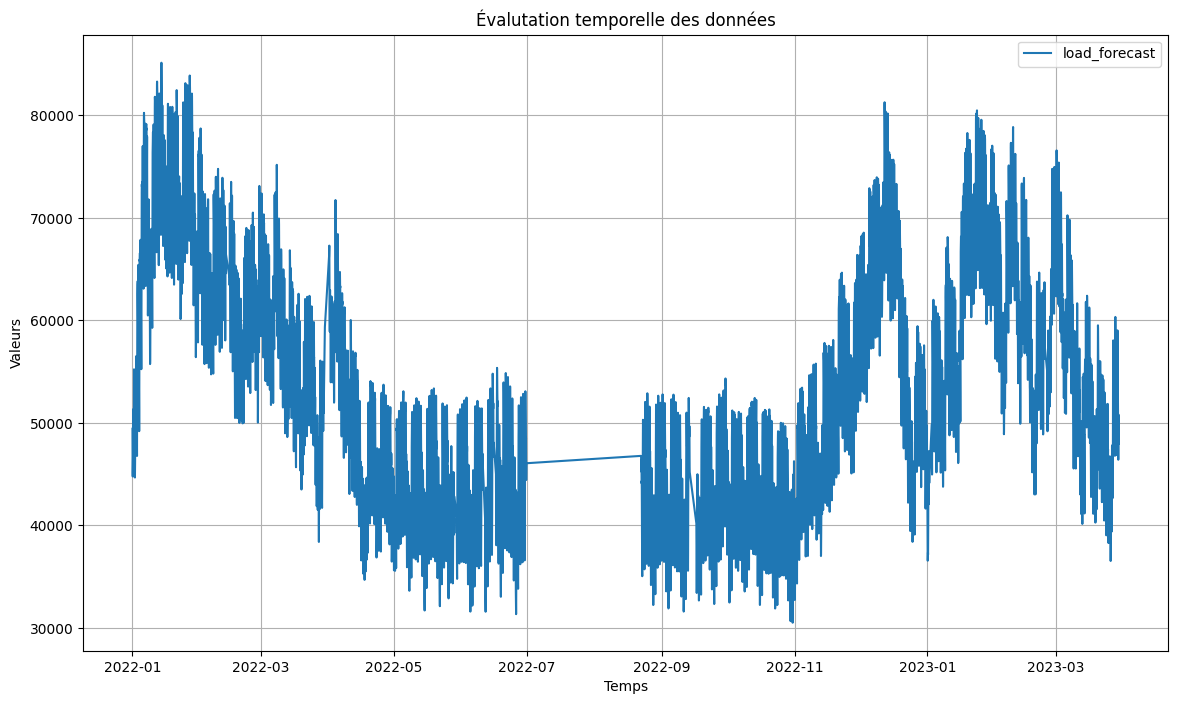

In [55]:
plot_time_series(x, 'DELIVERY_START', ['load_forecast'])

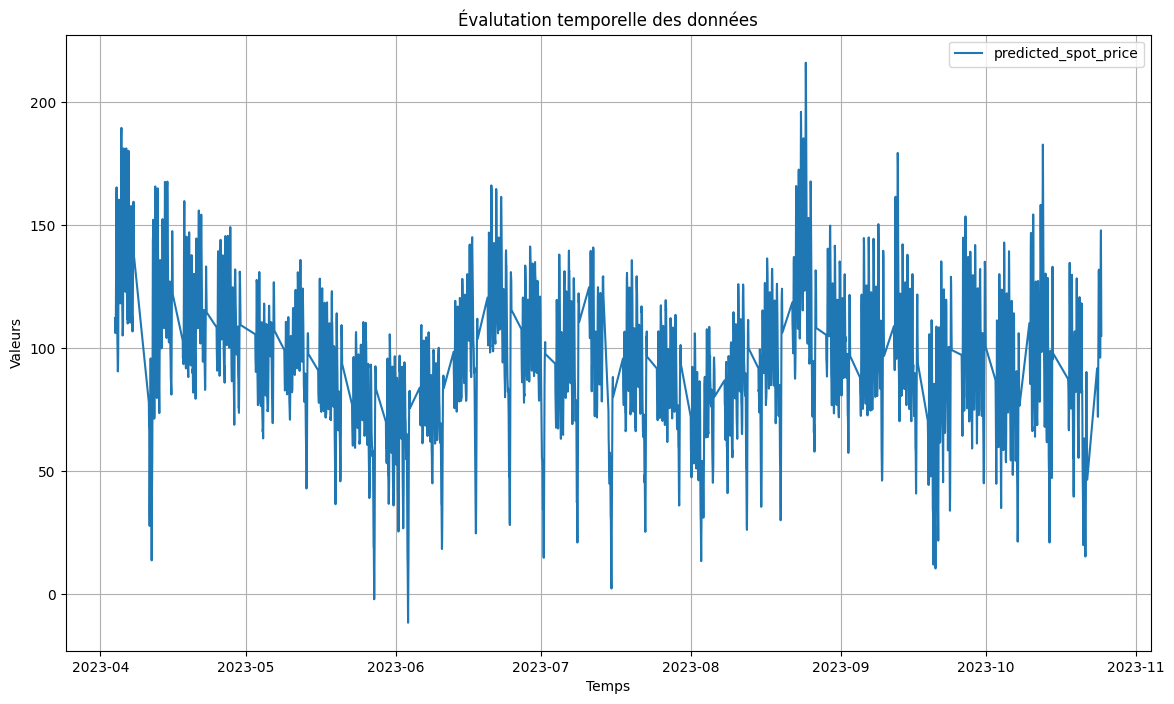

In [56]:
plot_time_series(x_challenge, 'DELIVERY_START', ['predicted_spot_price'])

# Traitement des données manquantes


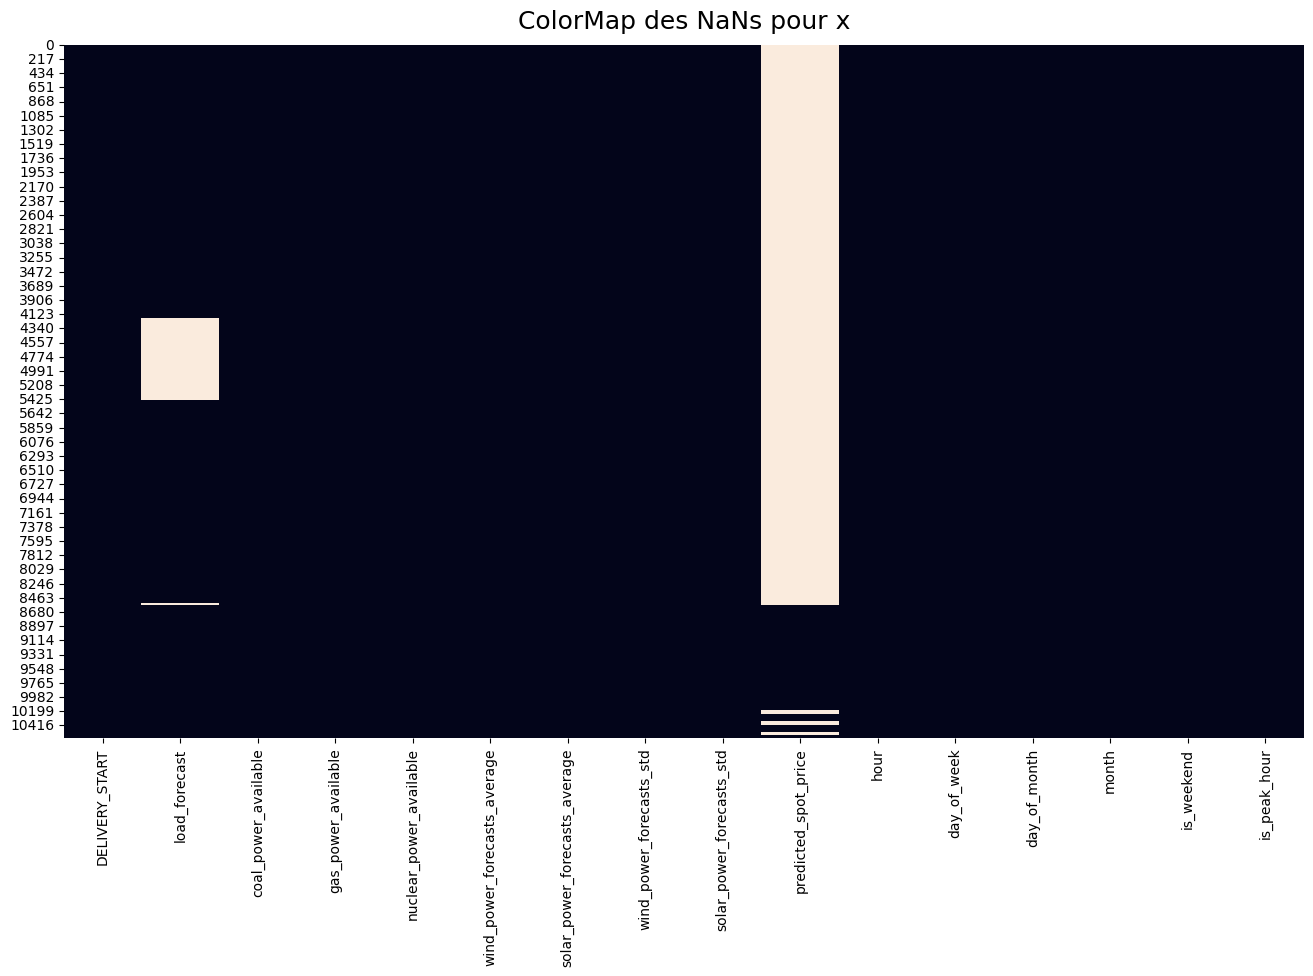

In [57]:
# Première visualisation des NaNs

nan_colormap(x, "ColorMap des NaNs pour x")
# nan_colormap(y, 'ColorMap des NaNs pour y')

# Il y a des NaNs dans x et x_challenge

# spot_columns(x_challenge)
# spot_columns(x_challenge)

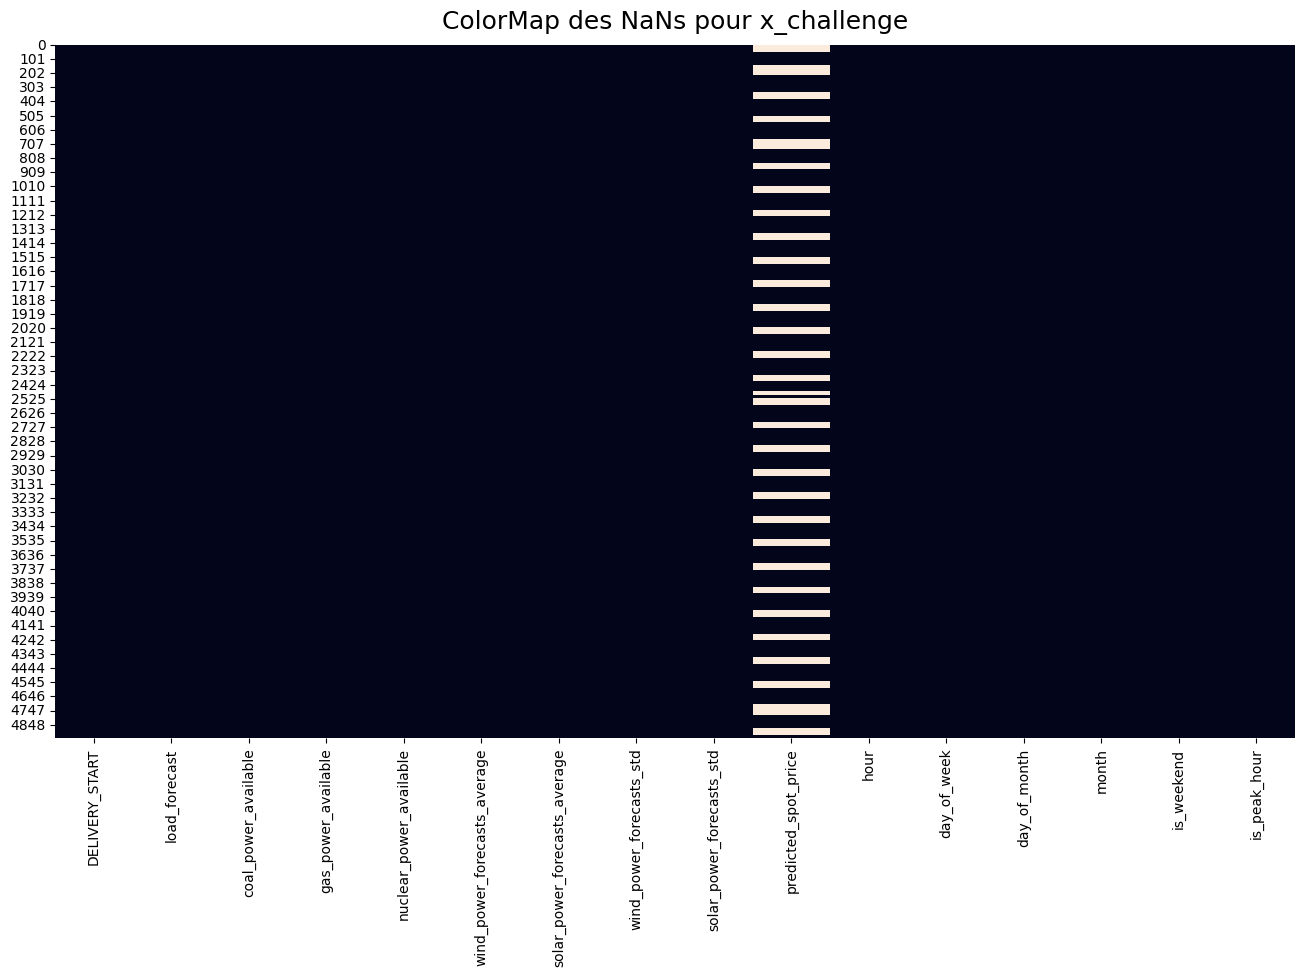

In [58]:
nan_colormap(x_challenge, "ColorMap des NaNs pour x_challenge")

# Remplissage de 'load_forecast'

In [59]:
# Je vais constuire un dataframe comme étant la concaténation de x et x_challenge pour prédire load_forecast
# en excluant predicted_spot_price comme la colonne est remplie de NaNs dans les deux csv

# x.to_csv('../data/drafts/x_draft.csv', index=False)
# x_challenge.to_csv('../data/drafts/x_challenge_draft.csv', index=False)

df1 = x[x['DELIVERY_START'] >= '2022-08-22 13:00:00+00:00'].drop(columns=['predicted_spot_price'])
df2 = x_challenge.drop(columns='predicted_spot_price')

# df1.tail(1)
df2.head(1)


DELIVERY_START  load_forecast  coal_power_available  \
0 2023-04-01 22:00:00+00:00        45814.0                3386.0   

   gas_power_available  nuclear_power_available  wind_power_forecasts_average  \
0              10902.0                  36705.0                        6359.0   

   solar_power_forecasts_average  wind_power_forecasts_std  \
0                            0.0                 56.764535   

   solar_power_forecasts_std  hour  day_of_week  day_of_month  month  \
0                        0.0    22            5             1      4   

   is_weekend  is_peak_hour  
0           0             0

In [60]:
df_to_predict = pd.concat([df1, df2], ignore_index=True)

# df_to_predict.to_csv('../data/drafts/x_to_predict.csv', index=False)

spot_columns(df_to_predict)

Column 'DELIVERY_START' : 0 NaN values
Column 'load_forecast' : 24 NaN values
Column 'coal_power_available' : 0 NaN values
Column 'gas_power_available' : 0 NaN values
Column 'nuclear_power_available' : 0 NaN values
Column 'wind_power_forecasts_average' : 0 NaN values
Column 'solar_power_forecasts_average' : 0 NaN values
Column 'wind_power_forecasts_std' : 0 NaN values
Column 'solar_power_forecasts_std' : 0 NaN values
Column 'hour' : 0 NaN values
Column 'day_of_week' : 0 NaN values
Column 'day_of_month' : 0 NaN values
Column 'month' : 0 NaN values
Column 'is_weekend' : 0 NaN values
Column 'is_peak_hour' : 0 NaN values


/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)


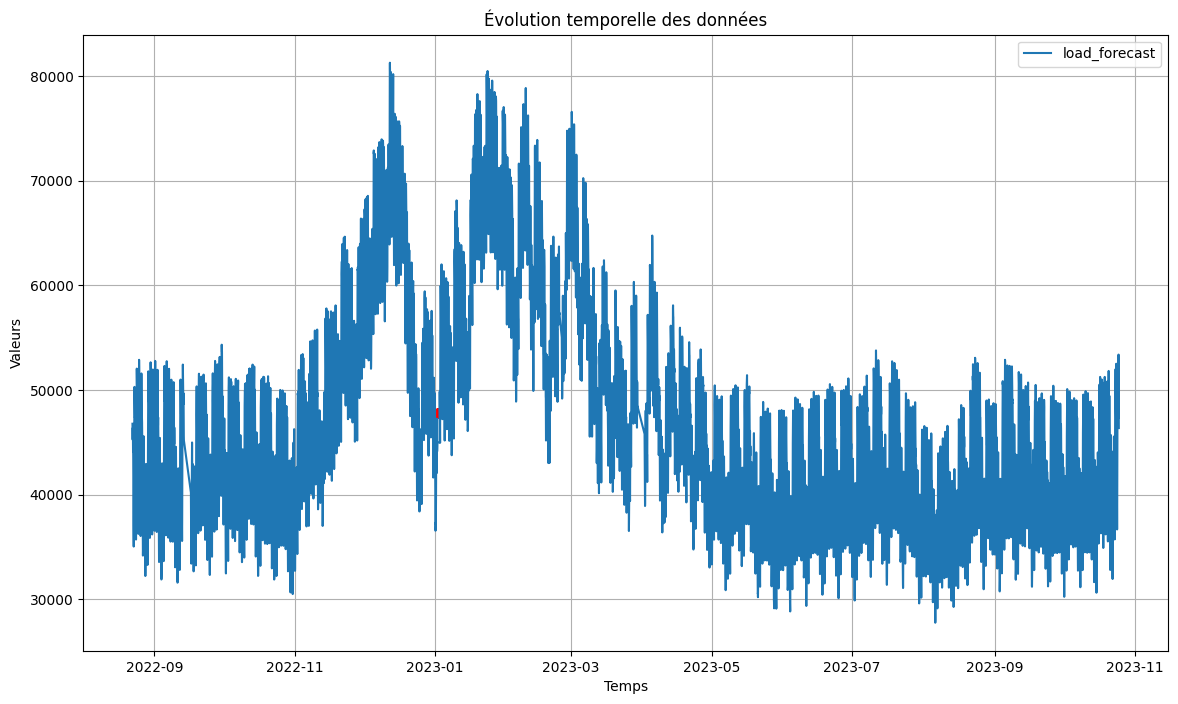

In [61]:
plot_time_series_with_nans(df_to_predict, 'DELIVERY_START', ['load_forecast'], meth='ffill')

In [62]:
spot_columns(df_to_predict)

Column 'DELIVERY_START' : 0 NaN values
Column 'load_forecast' : 0 NaN values
Column 'coal_power_available' : 0 NaN values
Column 'gas_power_available' : 0 NaN values
Column 'nuclear_power_available' : 0 NaN values
Column 'wind_power_forecasts_average' : 0 NaN values
Column 'solar_power_forecasts_average' : 0 NaN values
Column 'wind_power_forecasts_std' : 0 NaN values
Column 'solar_power_forecasts_std' : 0 NaN values
Column 'hour' : 0 NaN values
Column 'day_of_week' : 0 NaN values
Column 'day_of_month' : 0 NaN values
Column 'month' : 0 NaN values
Column 'is_weekend' : 0 NaN values
Column 'is_peak_hour' : 0 NaN values


In [63]:
x_train, x_test, y_train, y_test = train_test_split(
    df_to_predict.drop(columns=['load_forecast', 'DELIVERY_START']),
    df_to_predict.drop(columns=[
        'coal_power_available', 'gas_power_available', 'nuclear_power_available',
        'wind_power_forecasts_average', 'solar_power_forecasts_average',
        'wind_power_forecasts_std', 'solar_power_forecasts_std',
        'hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend', 'is_peak_hour'
    ]),
    test_size=.3
)

y_train.head(1)

DELIVERY_START  load_forecast
5254 2023-04-05 12:00:00+00:00        54210.0

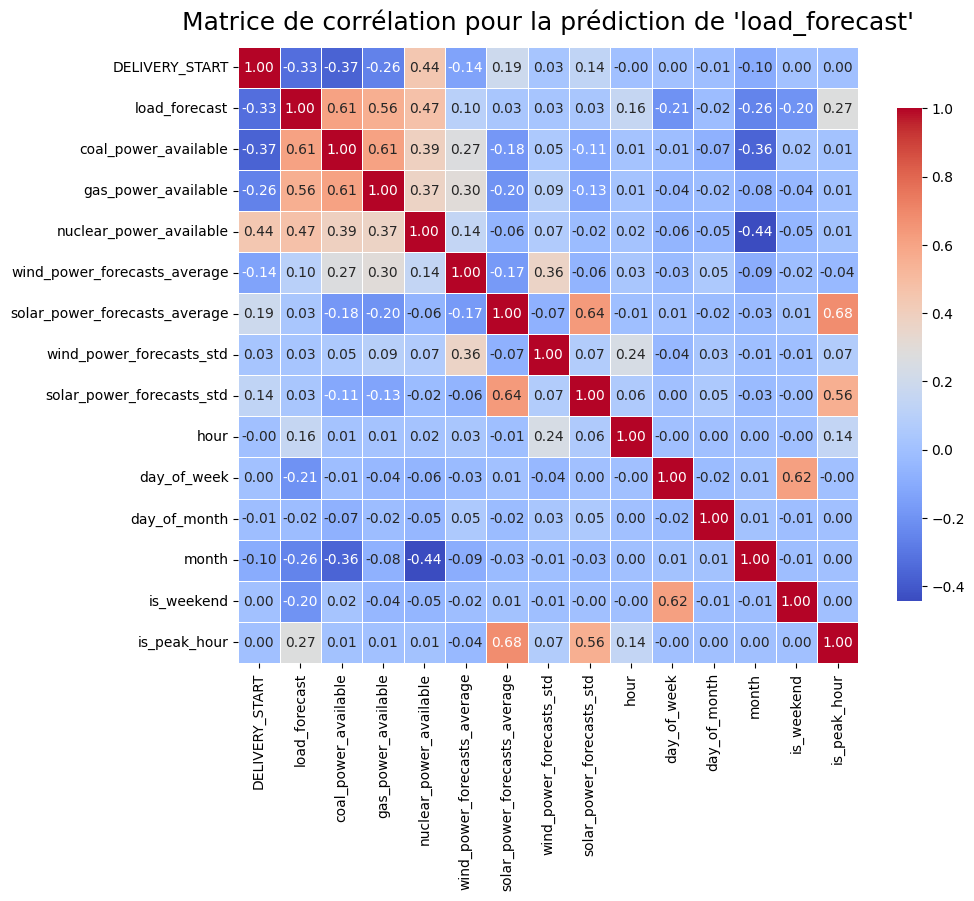

In [64]:
correlation_matrix(df_to_predict, 'pearson', 'Matrice de corrélation pour la prédiction de \'load_forecast\'')

In [65]:
forest = RandomForestRegressor(

)

boost = xgb.XGBRegressor(

)

cross_validation(forest, x_train, y_train['load_forecast'], 5, scoring_method='neg_mean_squared_error')

##### CROSS-VALIDATION SCORES ##### 

 neg_mean_squared_error  scores from cross-validation  [-3195207.09507267 -3381069.66665982 -2610632.65214113 -2994453.14420417
 -3380873.67489378] 
 neg_mean_squared_error  mean from cross-validation  -3112447.2465943135 
 Standard deviation  288721.4712821632 

 ###################################


In [66]:
lf_to_predict = x[('2022-06-30 22:00:00+00:00' <= x['DELIVERY_START']) & (x['DELIVERY_START'] <= '2022-08-22 12:00:00+00:00')]

lf_y = lf_to_predict.drop(columns=[
    'coal_power_available', 'gas_power_available', 'nuclear_power_available',
    'wind_power_forecasts_average', 'solar_power_forecasts_average',
    'wind_power_forecasts_std', 'solar_power_forecasts_std',
    'hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend', 'is_peak_hour',
    'predicted_spot_price'
])

lf_x = lf_to_predict.drop(columns=[
    'DELIVERY_START', 'load_forecast', 'predicted_spot_price'
])

lf_x.head(5)


coal_power_available  gas_power_available  nuclear_power_available  \
4174                2226.0              10555.0                  28620.0   
4175                2226.0              10555.0                  28620.0   
4176                2226.0              10555.0                  28620.0   
4177                2226.0              10555.0                  28620.0   
4178                2226.0              10555.0                  28620.0   

      wind_power_forecasts_average  solar_power_forecasts_average  \
4174                        2440.0                            0.0   
4175                        2458.0                            0.0   
4176                        2488.0                            0.0   
4177                        2503.0                            0.0   
4178                        2379.0                            0.0   

      wind_power_forecasts_std  solar_power_forecasts_std  hour  day_of_week  \
4174                 25.539985                        0.0    22            3   
4175                 48.738464                        0.0    23            3   
4176                 72.699332                        0.0     0            4   
4177                 64.109409                        0.0     1            4   
4178                 61.780261                        0.0     2            4   

      day_of_month  month  is_weekend  is_peak_hour  
4174            30      6           0             0  
4175            30      6           0             0  
4176             1      7           0             0  
4177             1      7           0             0  
4178             1      7           0             0

In [67]:
forest.fit(x_train, y_train['load_forecast'])

lf_y['load_forecast'] = forest.predict(lf_x)

In [68]:
lf_to_predict.head(5)

DELIVERY_START  load_forecast  coal_power_available  \
4174 2022-06-30 22:00:00+00:00            NaN                2226.0   
4175 2022-06-30 23:00:00+00:00            NaN                2226.0   
4176 2022-07-01 00:00:00+00:00            NaN                2226.0   
4177 2022-07-01 01:00:00+00:00            NaN                2226.0   
4178 2022-07-01 02:00:00+00:00            NaN                2226.0   

      gas_power_available  nuclear_power_available  \
4174              10555.0                  28620.0   
4175              10555.0                  28620.0   
4176              10555.0                  28620.0   
4177              10555.0                  28620.0   
4178              10555.0                  28620.0   

      wind_power_forecasts_average  solar_power_forecasts_average  \
4174                        2440.0                            0.0   
4175                        2458.0                            0.0   
4176                        2488.0                            0.0   
4177                        2503.0                            0.0   
4178                        2379.0                            0.0   

      wind_power_forecasts_std  solar_power_forecasts_std  \
4174                 25.539985                        0.0   
4175                 48.738464                        0.0   
4176                 72.699332                        0.0   
4177                 64.109409                        0.0   
4178                 61.780261                        0.0   

      predicted_spot_price  hour  day_of_week  day_of_month  month  \
4174                   NaN    22            3            30      6   
4175                   NaN    23            3            30      6   
4176                   NaN     0            4             1      7   
4177                   NaN     1            4             1      7   
4178                   NaN     2            4             1      7   

      is_weekend  is_peak_hour  
4174           0             0  
4175           0             0  
4176           0             0  
4177           0             0  
4178           0             0

In [69]:
lf_to_predict['load_forecast'] = lf_y['load_forecast']

lf_to_predict.head(5)

/var/folders/5w/37p1__596xz7ylx6ltmmggph0000gn/T/ipykernel_15922/3313121633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lf_to_predict['load_forecast'] = lf_y['load_forecast']


DELIVERY_START  load_forecast  coal_power_available  \
4174 2022-06-30 22:00:00+00:00       41162.94                2226.0   
4175 2022-06-30 23:00:00+00:00       38152.72                2226.0   
4176 2022-07-01 00:00:00+00:00       37749.84                2226.0   
4177 2022-07-01 01:00:00+00:00       36748.75                2226.0   
4178 2022-07-01 02:00:00+00:00       36378.12                2226.0   

      gas_power_available  nuclear_power_available  \
4174              10555.0                  28620.0   
4175              10555.0                  28620.0   
4176              10555.0                  28620.0   
4177              10555.0                  28620.0   
4178              10555.0                  28620.0   

      wind_power_forecasts_average  solar_power_forecasts_average  \
4174                        2440.0                            0.0   
4175                        2458.0                            0.0   
4176                        2488.0                            0.0   
4177                        2503.0                            0.0   
4178                        2379.0                            0.0   

      wind_power_forecasts_std  solar_power_forecasts_std  \
4174                 25.539985                        0.0   
4175                 48.738464                        0.0   
4176                 72.699332                        0.0   
4177                 64.109409                        0.0   
4178                 61.780261                        0.0   

      predicted_spot_price  hour  day_of_week  day_of_month  month  \
4174                   NaN    22            3            30      6   
4175                   NaN    23            3            30      6   
4176                   NaN     0            4             1      7   
4177                   NaN     1            4             1      7   
4178                   NaN     2            4             1      7   

      is_weekend  is_peak_hour  
4174           0             0  
4175           0             0  
4176           0             0  
4177           0             0  
4178           0             0

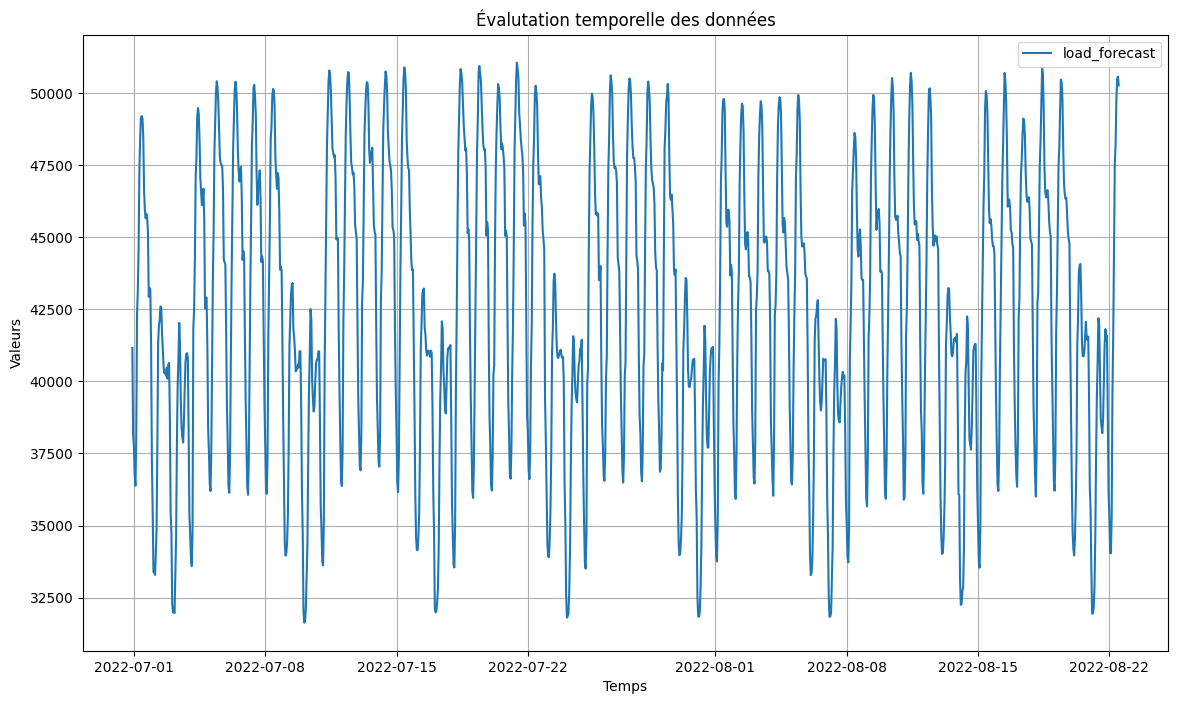

In [70]:
plot_time_series(lf_to_predict, 'DELIVERY_START', ['load_forecast'])

/Users/hugopuybareau/Documents/GitHub/ELMY_DATA_CHALLENGE/scripts/functions.py:265: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method=meth)


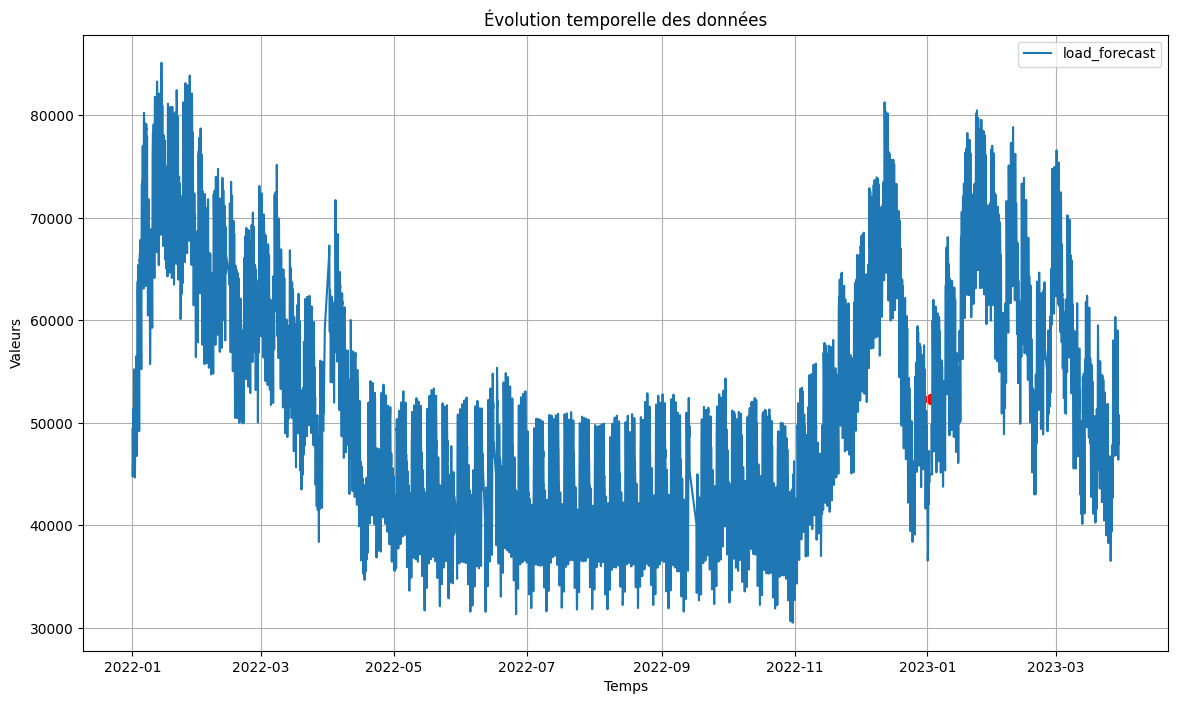

In [71]:
x_new = x.copy()

x_new[('2022-06-30 22:00:00+00:00' <= x_new['DELIVERY_START']) & (x_new['DELIVERY_START'] <= '2022-08-22 12:00:00+00:00')] = lf_to_predict

plot_time_series_with_nans(x_new, 'DELIVERY_START', ['load_forecast'], 'ffill')

# Ok parfait ça fonctionne très bien. Plus qu'à remplacer 'predicted_spot_price'

# Remplacement de 'predicted_spot_price'

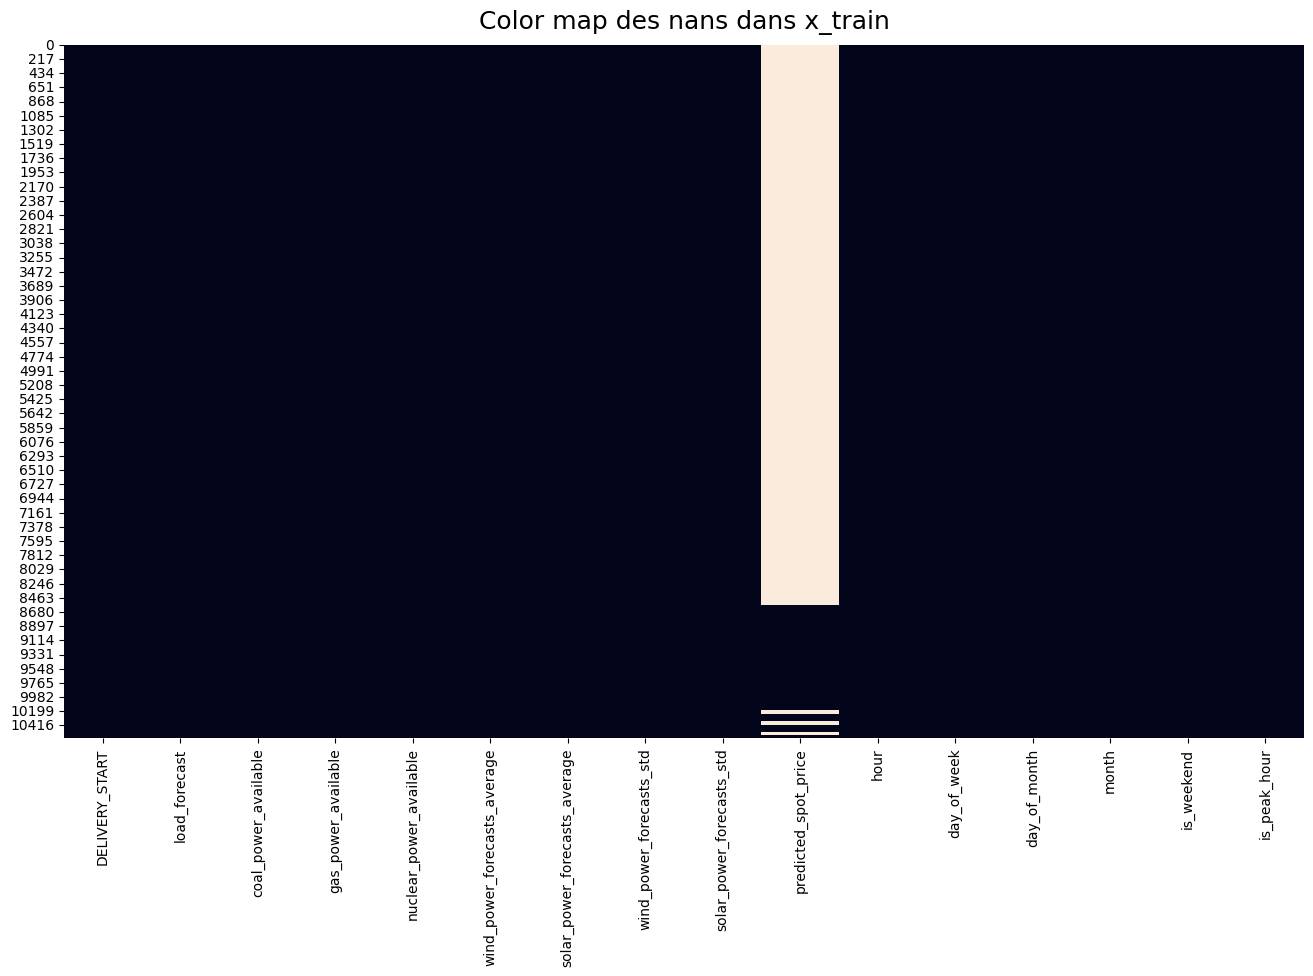

In [72]:
nan_colormap(x_new, 'Color map des nans dans x_train')

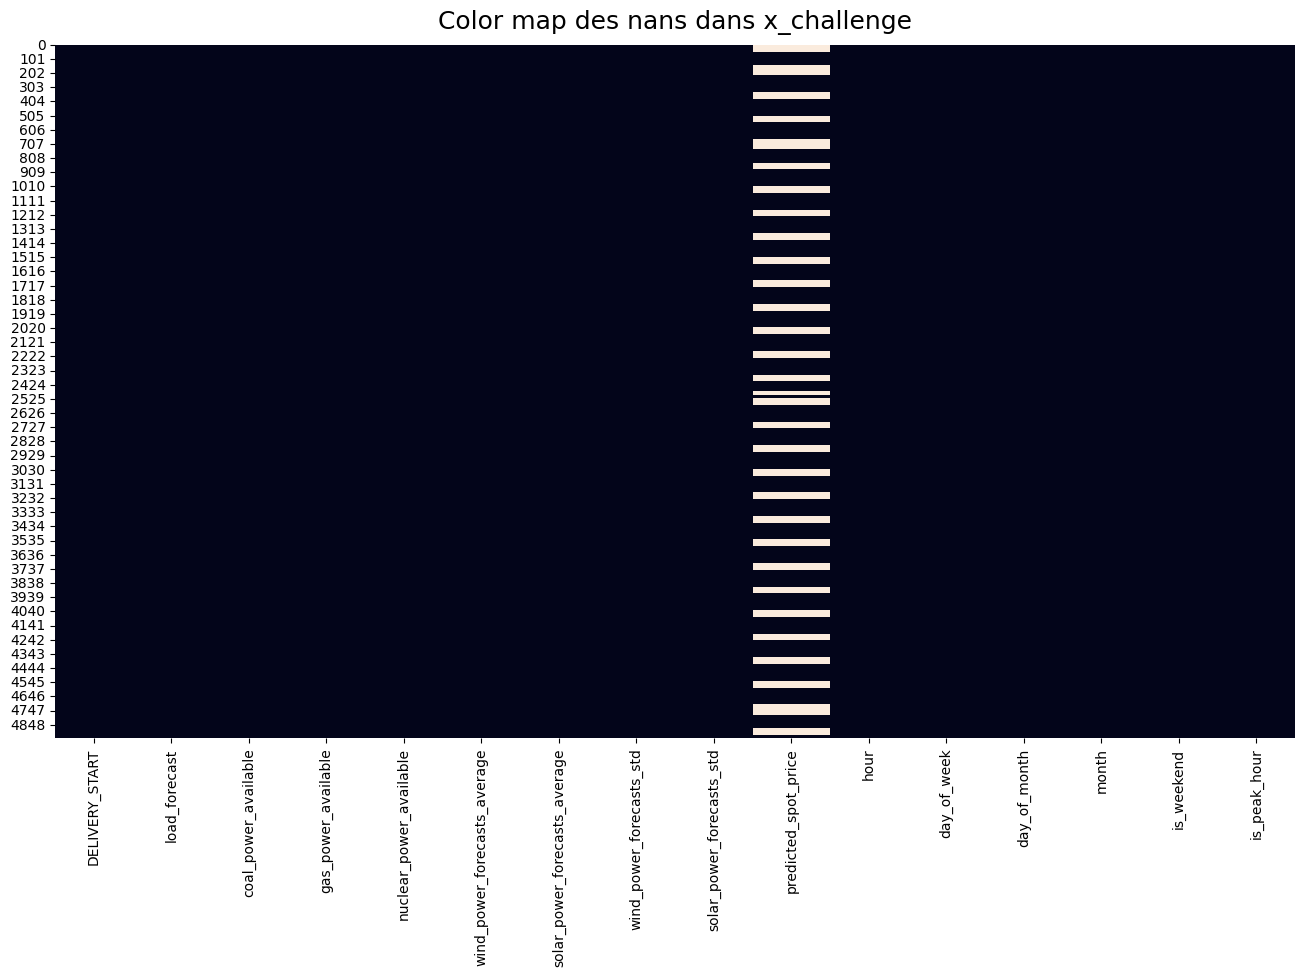

In [73]:
nan_colormap(x_challenge, 'Color map des nans dans x_challenge')

In [74]:
# Comme il manque des valeurs dans les deux dataframes, je vais coler ces deux derniers. À partir de ça
# je vais créer deux nouveaux dataframe, un où il manque les valeurs de 'predicted_spot_price' et un où ce
# n'est pas le cas. À partir de là, je pourrai entraîner trois modèles de régression différent qui me permettront
# de faire une moyenne des predictions et donc remplir ma colonne dans les deux dataframes. 

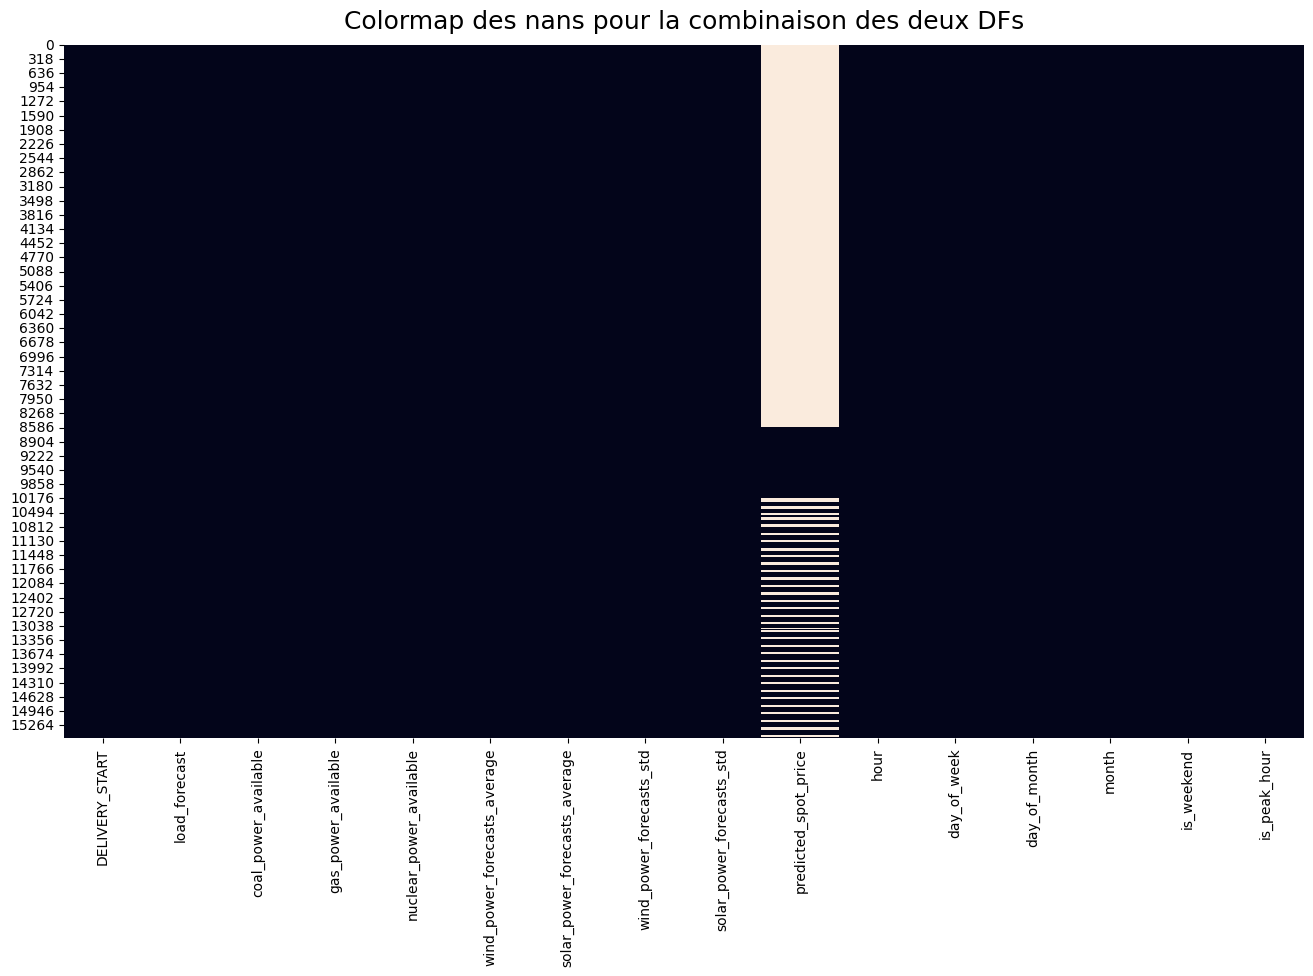

In [75]:
combined_df = pd.concat([x_new, x_challenge], ignore_index=True)

combined_df.to_csv('../data/drafts/x_to_predict_2.csv', index=False)

nan_colormap(combined_df, 'Colormap des nans pour la combinaison des deux DFs')

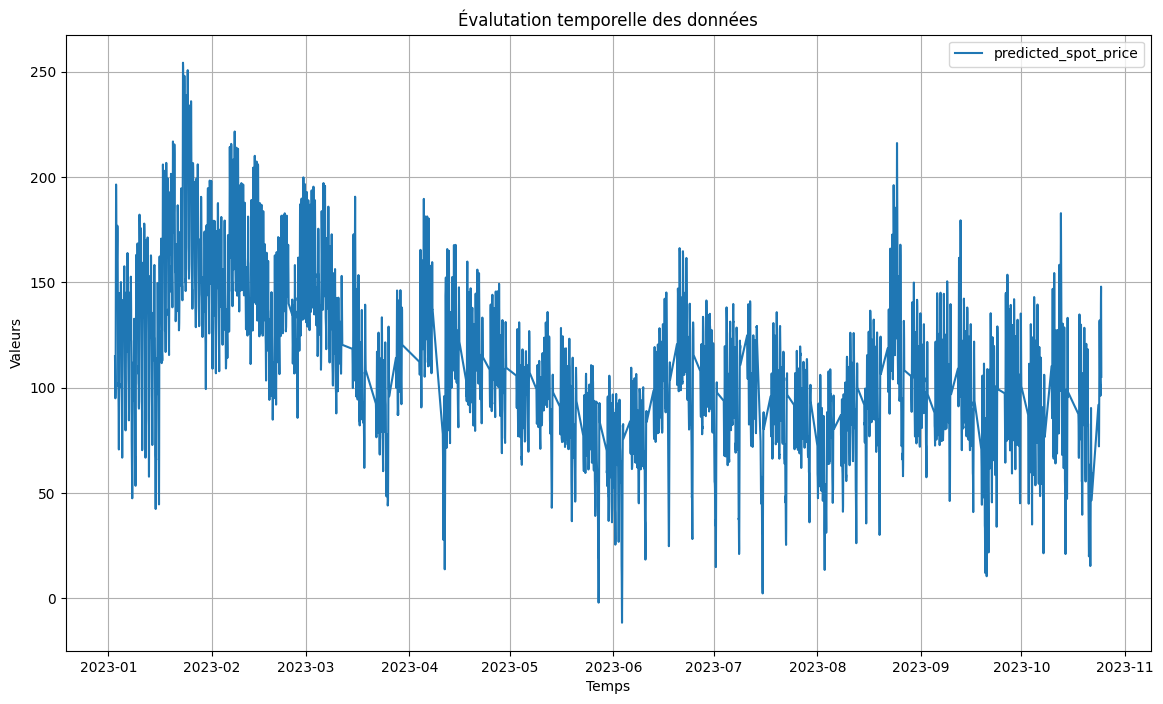

In [76]:
plot_time_series(combined_df, 'DELIVERY_START', ['predicted_spot_price'])

# En réalité ça commence à 2022-01 c'est juste qu'il représente pas les NaNs

In [77]:
# Séparation des données

df_values = combined_df.dropna(subset=['predicted_spot_price'])
df_missing_values = combined_df[combined_df['predicted_spot_price'].isna()]

features = df_values.drop(columns=['predicted_spot_price'], axis=1)
target = df_values.drop(columns=[
    'load_forecast',
    'coal_power_available', 'gas_power_available', 'nuclear_power_available',
    'wind_power_forecasts_average', 'solar_power_forecasts_average',
    'wind_power_forecasts_std', 'solar_power_forecasts_std',
    'hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend', 'is_peak_hour'
])

target.head(5)

DELIVERY_START  predicted_spot_price
8567 2023-01-03 00:00:00+00:00                114.88
8568 2023-01-03 01:00:00+00:00                110.62
8569 2023-01-03 02:00:00+00:00                105.31
8570 2023-01-03 03:00:00+00:00                 94.95
8571 2023-01-03 04:00:00+00:00                 97.82

In [78]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=.2, random_state=2)

models = {
    # "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=3),
    # "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=4),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=5)
}

predictions = {}

for name, model in models.items() :
    model.fit(x_train.drop(columns=['DELIVERY_START'], axis=1), y_train['predicted_spot_price'])
    preds = model.predict(x_test.drop(columns=['DELIVERY_START'], axis=1))
    predictions[name] = preds
    mse = mean_squared_error(y_test['predicted_spot_price'], preds)
    print(f'{name} mse : {mse}')

# Je voulais faire une moyenne des trois mais le XGBoost est bien trop fort donc je vais juste faire
# la moyenne entre lui et la RandomForest



Random Forest mse : 107.2840898116555
XGBoost mse : 50.72376665802705


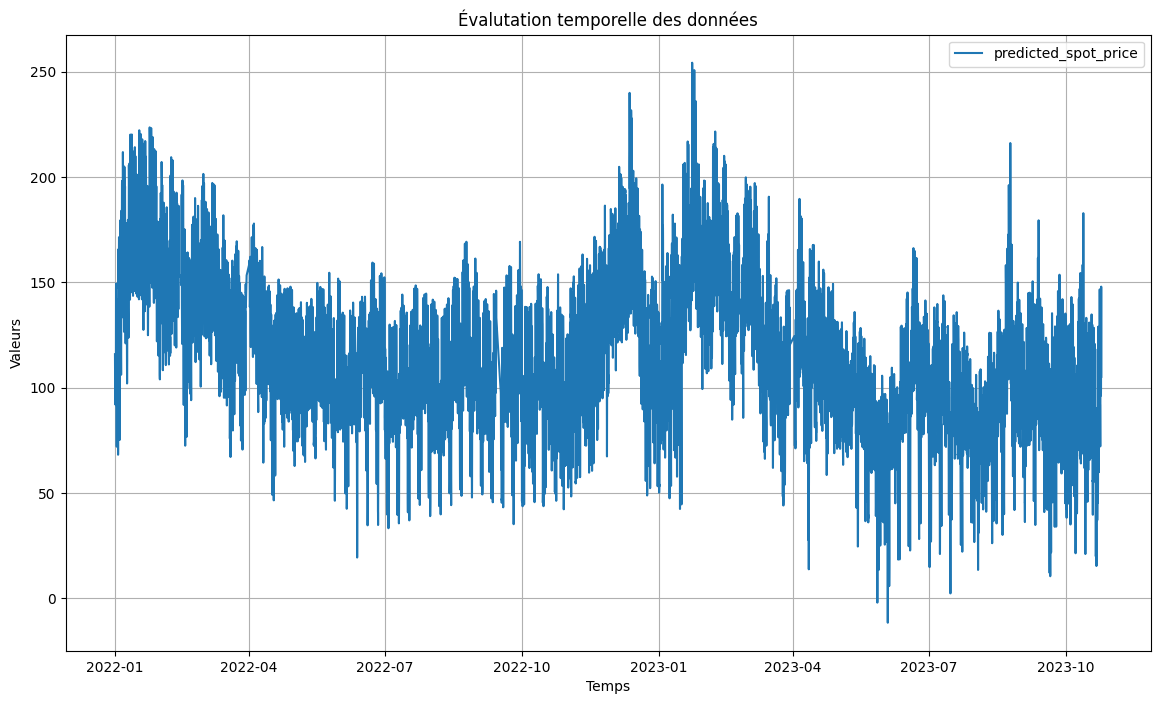

In [79]:
missing_features = df_missing_values.drop(columns=['predicted_spot_price', 'DELIVERY_START'], axis=1)

# Calcul de la moyenne des prédictions des différents modèles
predicted_missing_values = np.mean(
    [model.predict(missing_features) for model in models.values()],
    axis=0
)

# Remise des prédictions dans le DataFrame original
combined_df.loc[combined_df['predicted_spot_price'].isna(), 'predicted_spot_price'] = predicted_missing_values

plot_time_series(combined_df, 'DELIVERY_START', ['predicted_spot_price'])

# Franchement c'est très bien, hâte d'upload un score avec ça. Même si je commence à avoir l'habitude
# que tout soit toujours moins bien qu'un vieux xgboost de merde. 

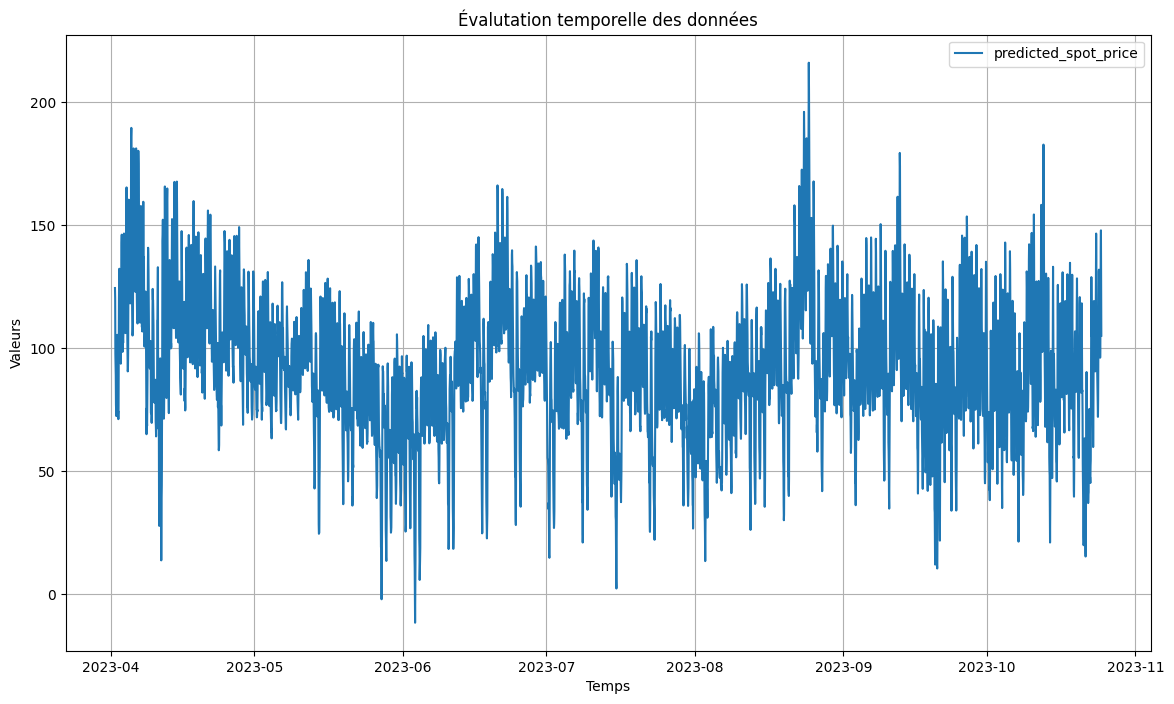

In [80]:
# On reforme x et x_challenge

x_new = combined_df.iloc[:len(x)]
x_challenge_new = combined_df.iloc[len(x):]

plot_time_series(x_challenge_new, 'DELIVERY_START', ['predicted_spot_price'])

# Exploratory Data Analysis (EDA)

Recherche de valeurs aberrantes

Analyse univariée

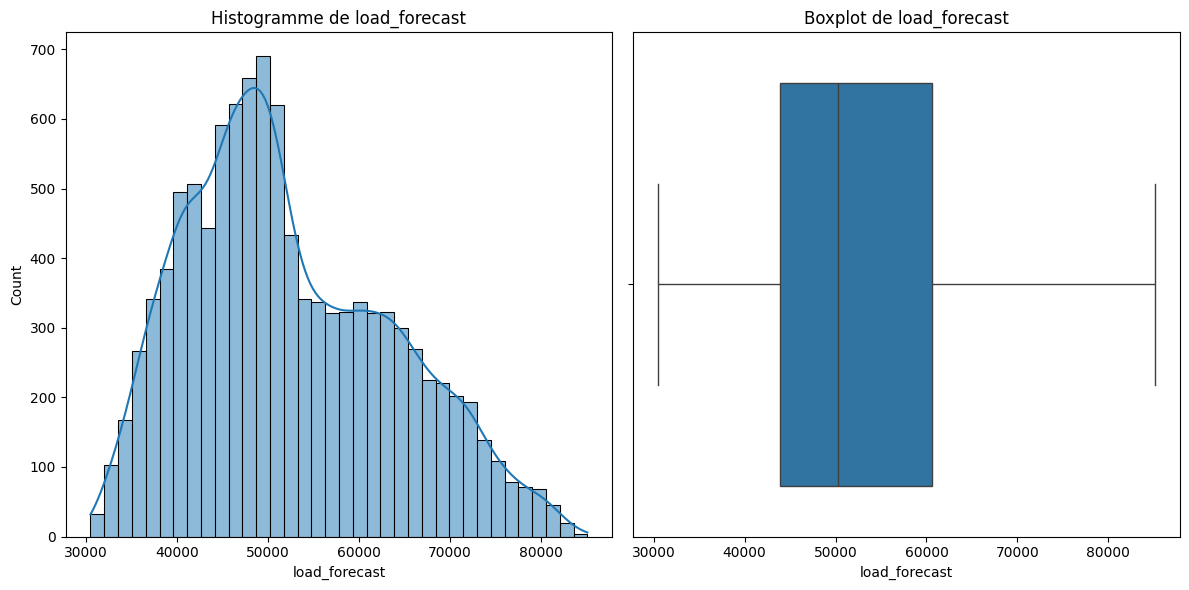

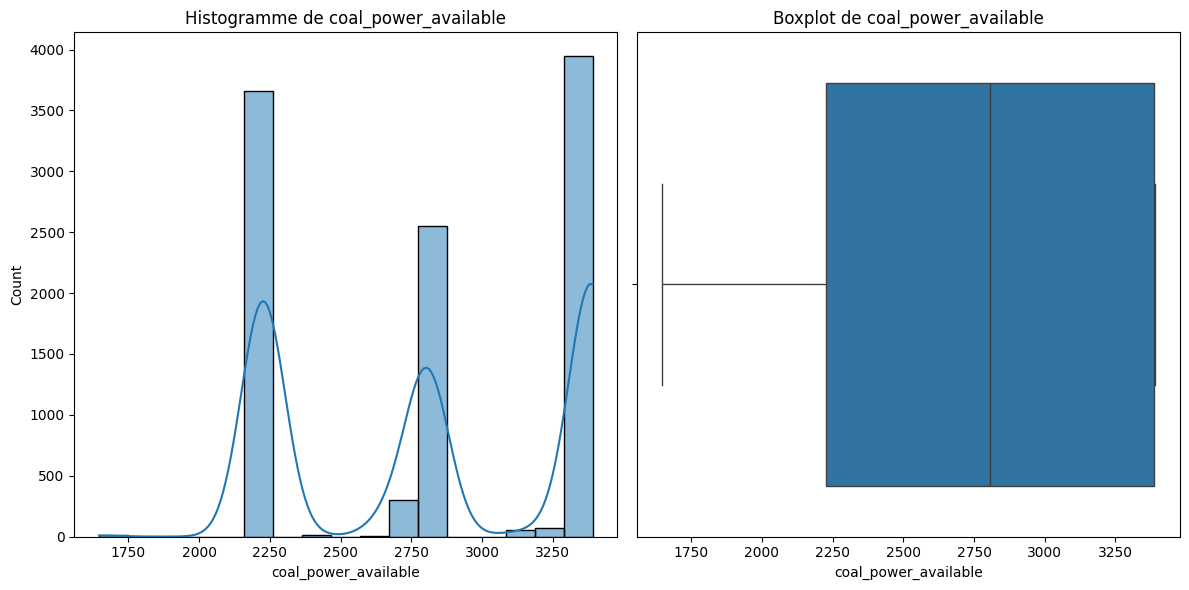

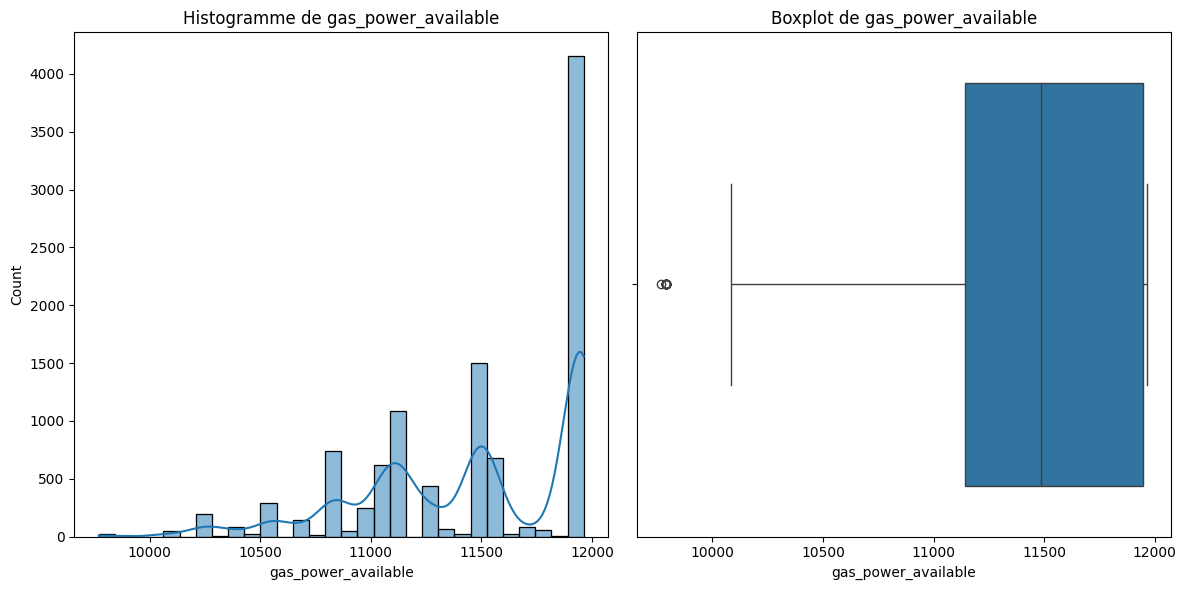

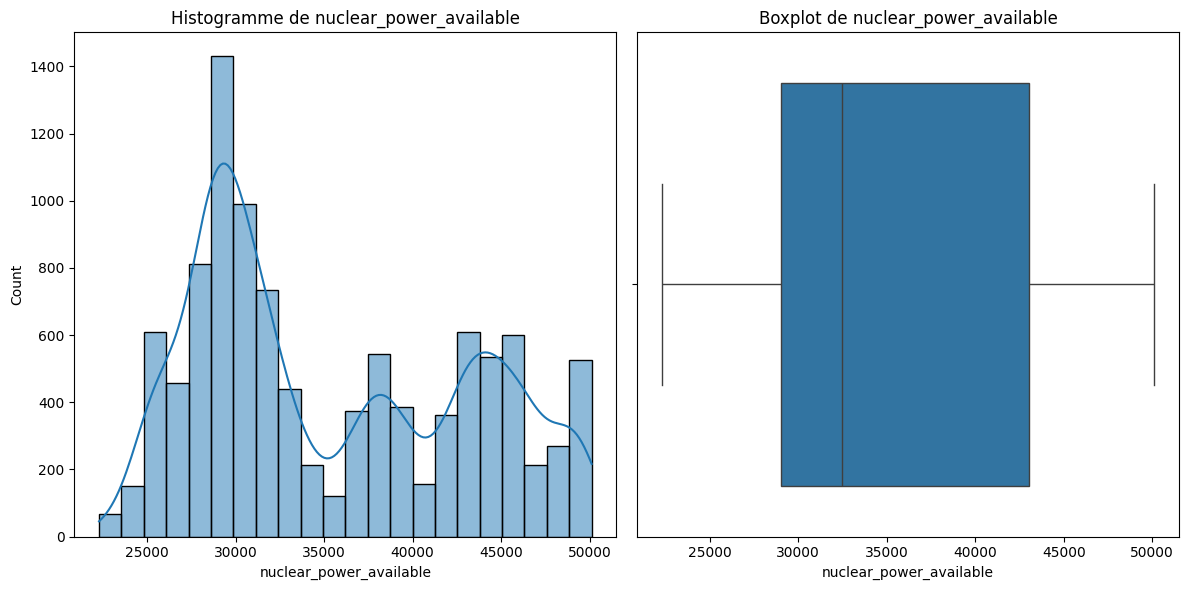

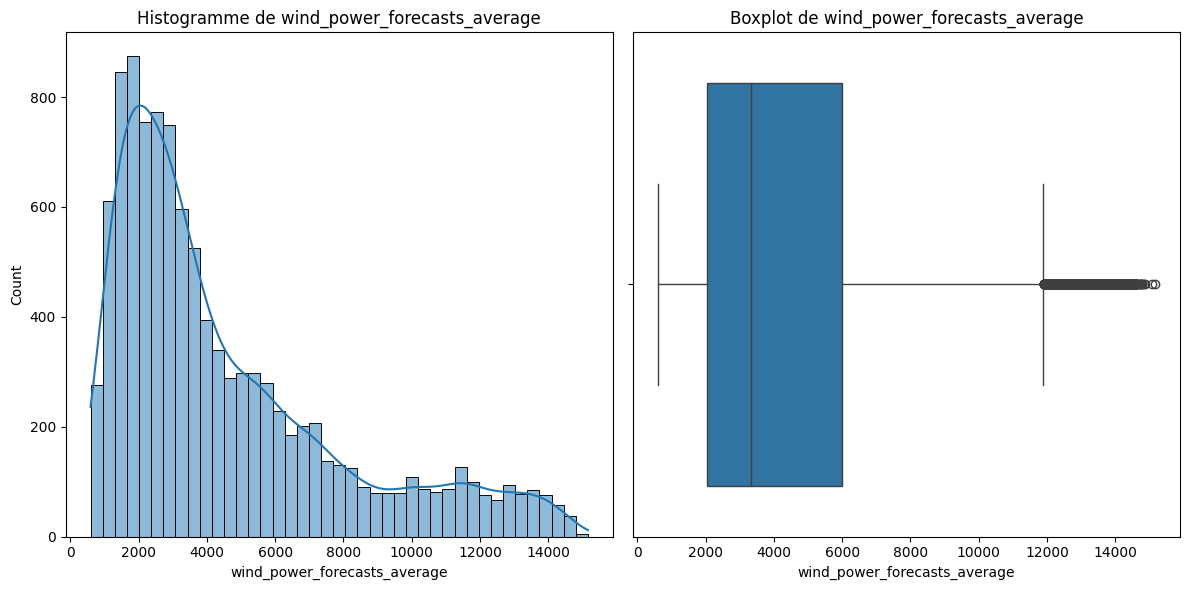

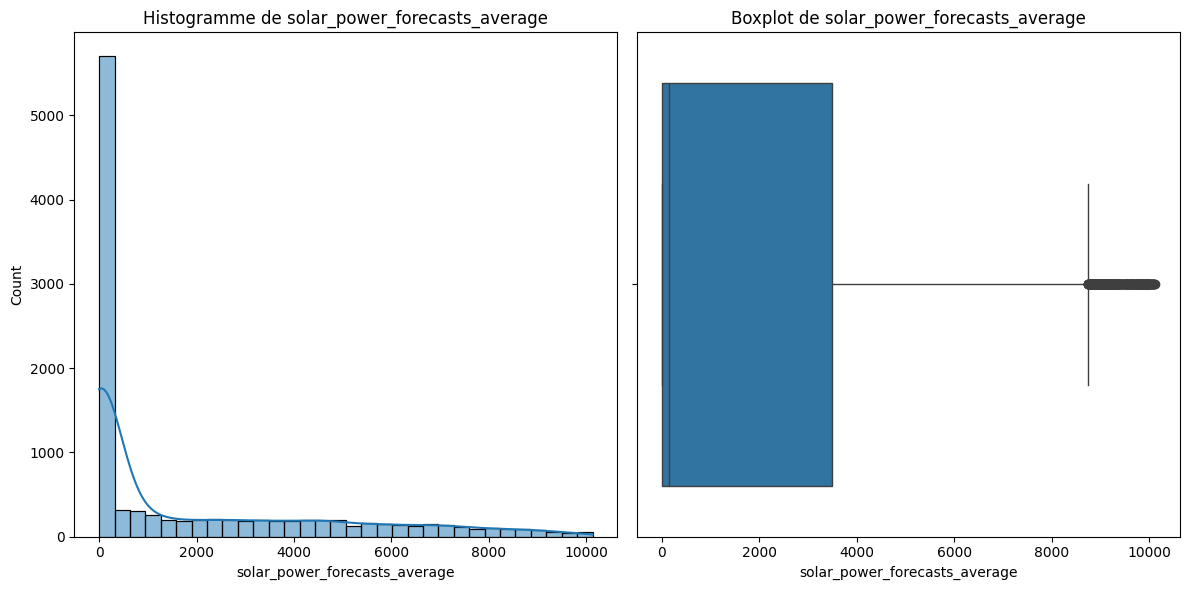

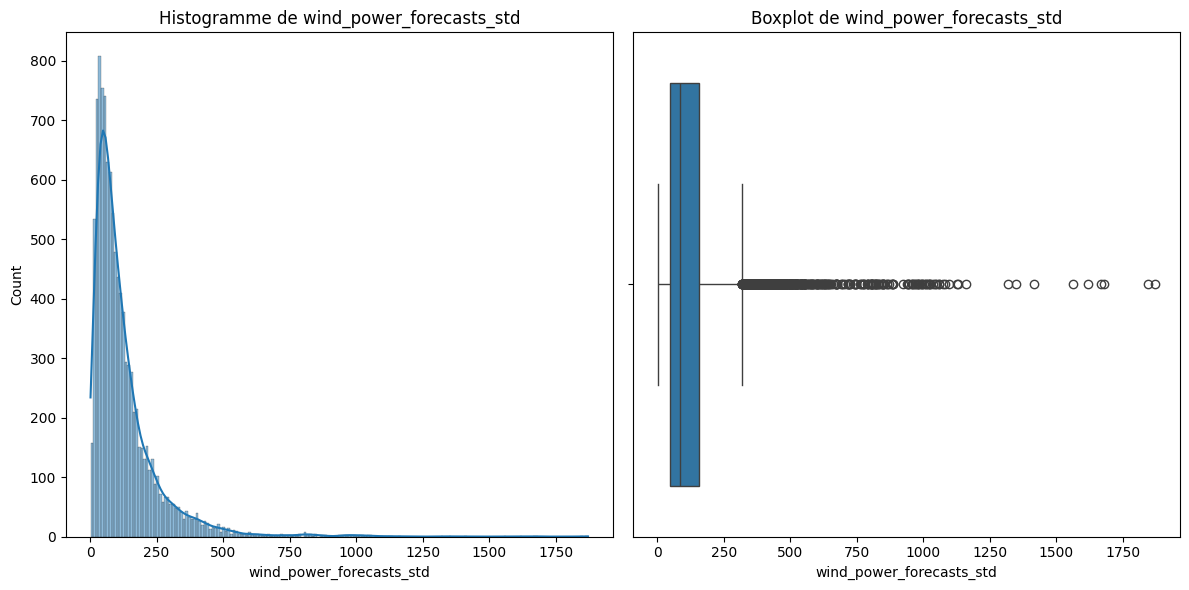

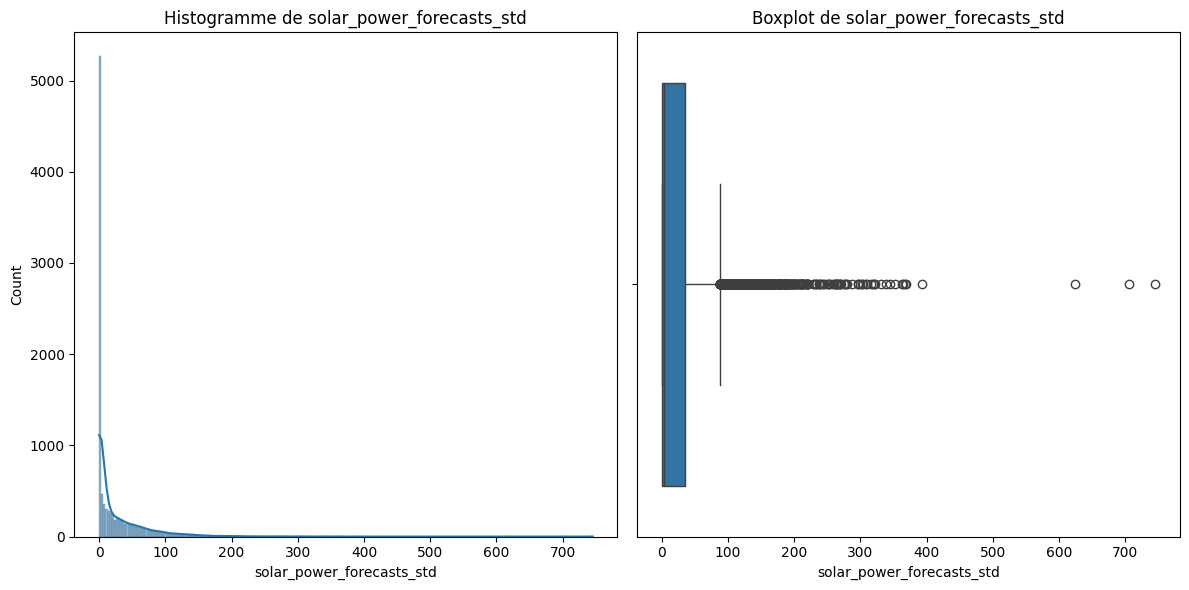

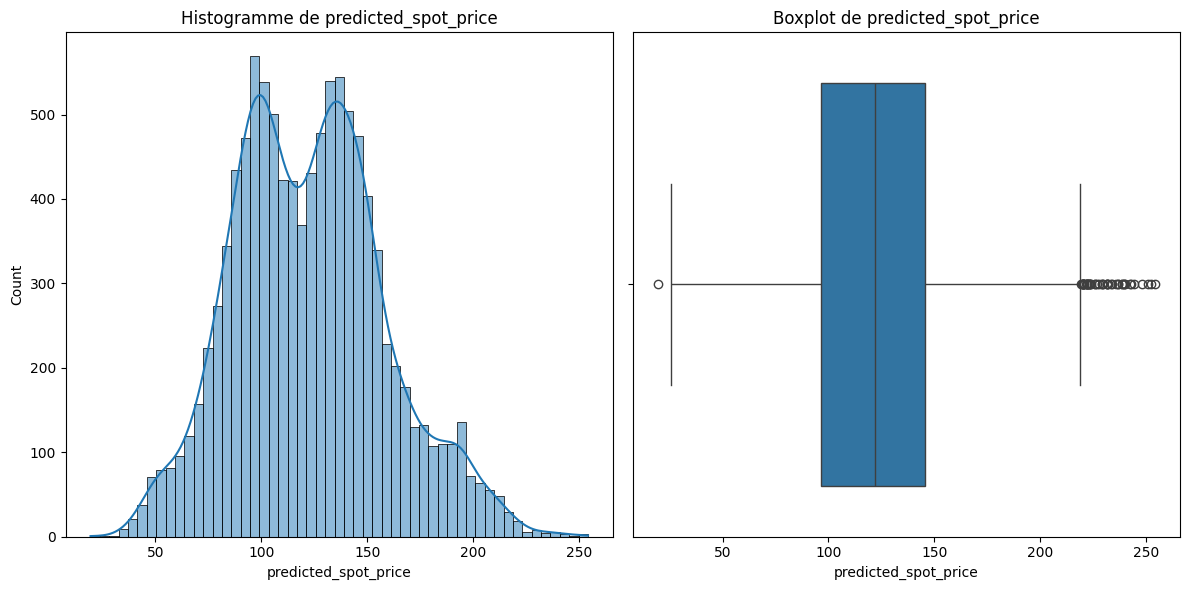

In [81]:
deviant_columns = [
    'load_forecast', 
    'coal_power_available', 'gas_power_available', 'nuclear_power_available',
    'wind_power_forecasts_average','solar_power_forecasts_average',
    'wind_power_forecasts_std', 'solar_power_forecasts_std',
    'predicted_spot_price'
]

univariate_analysis(x_new, deviant_columns, [])

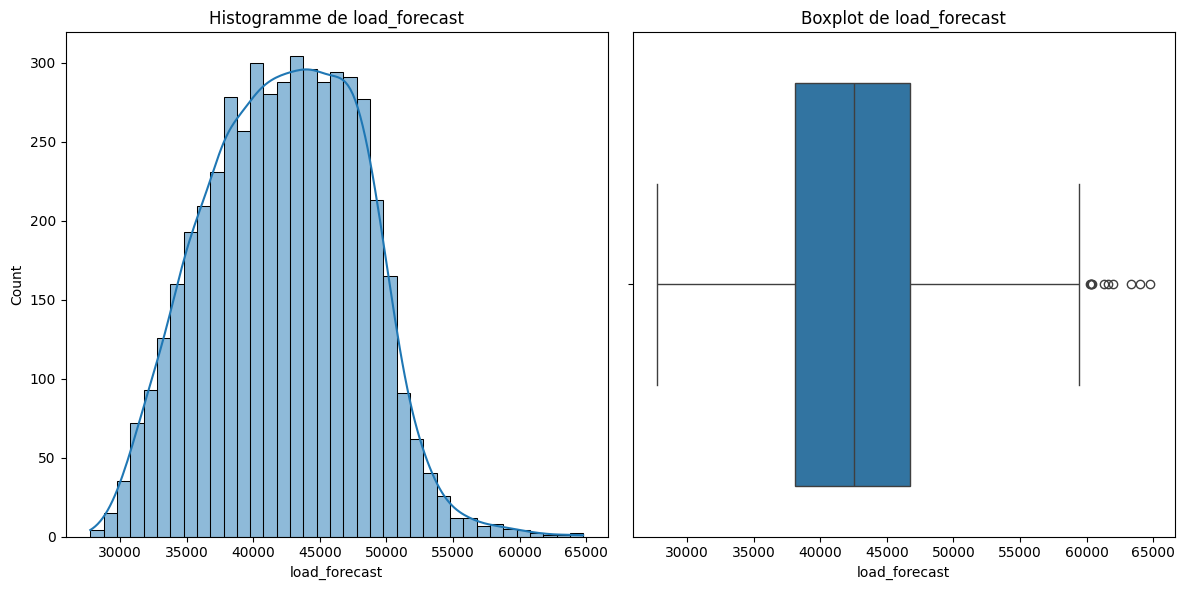

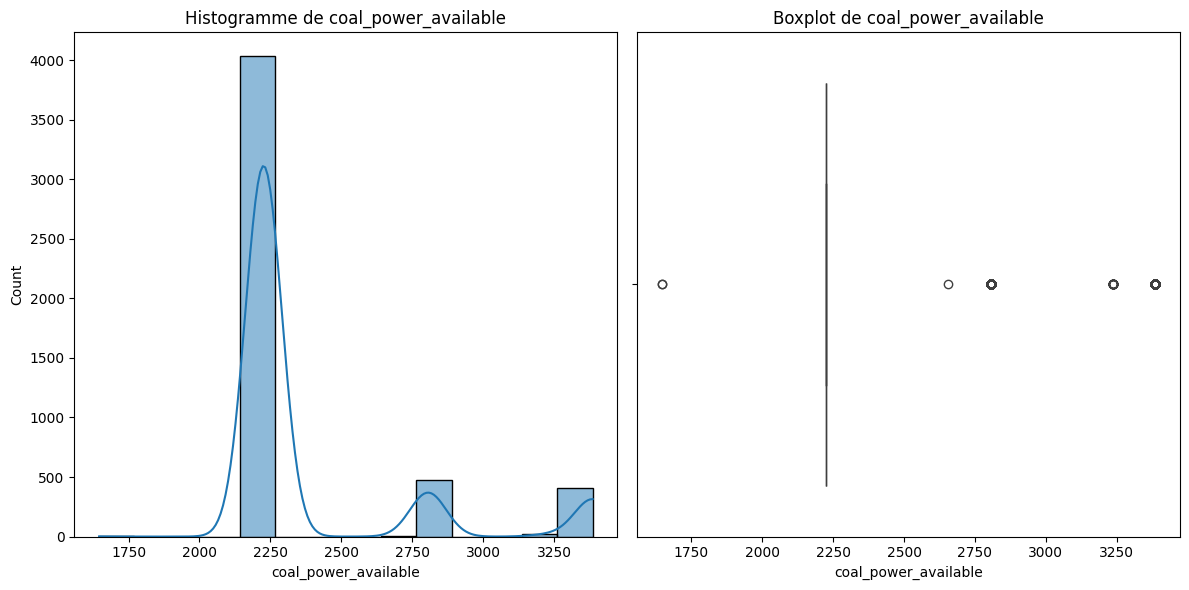

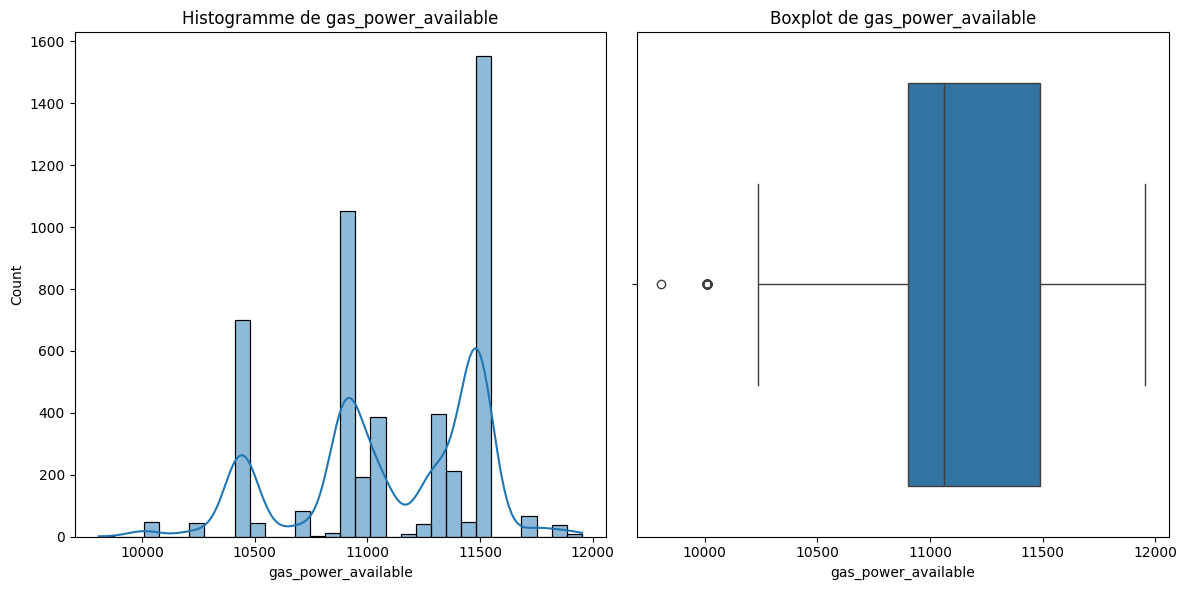

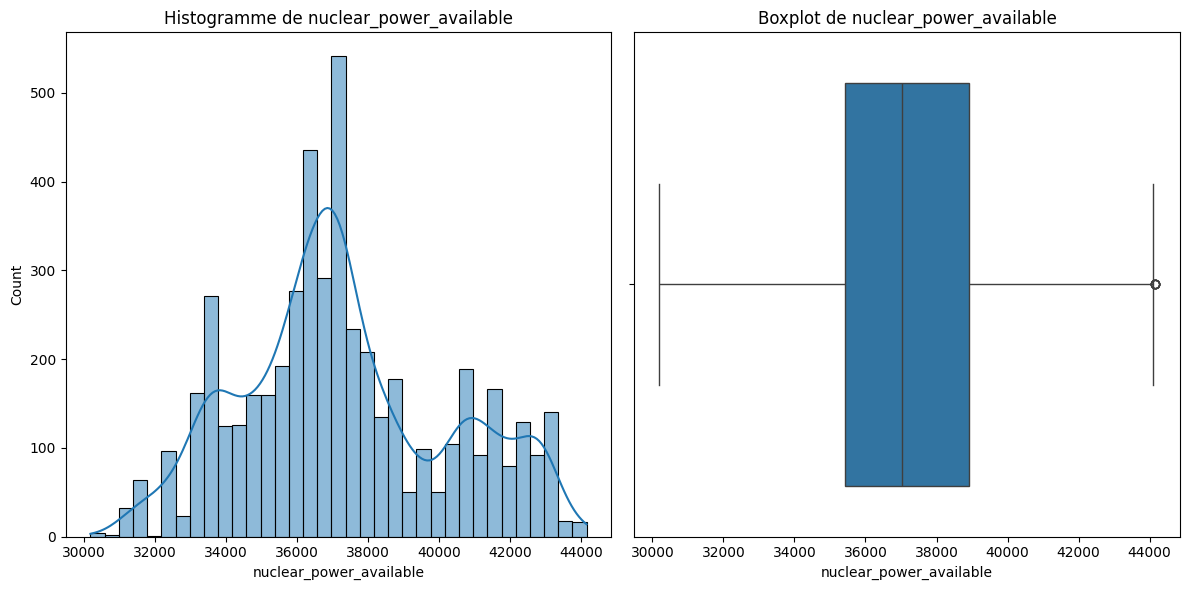

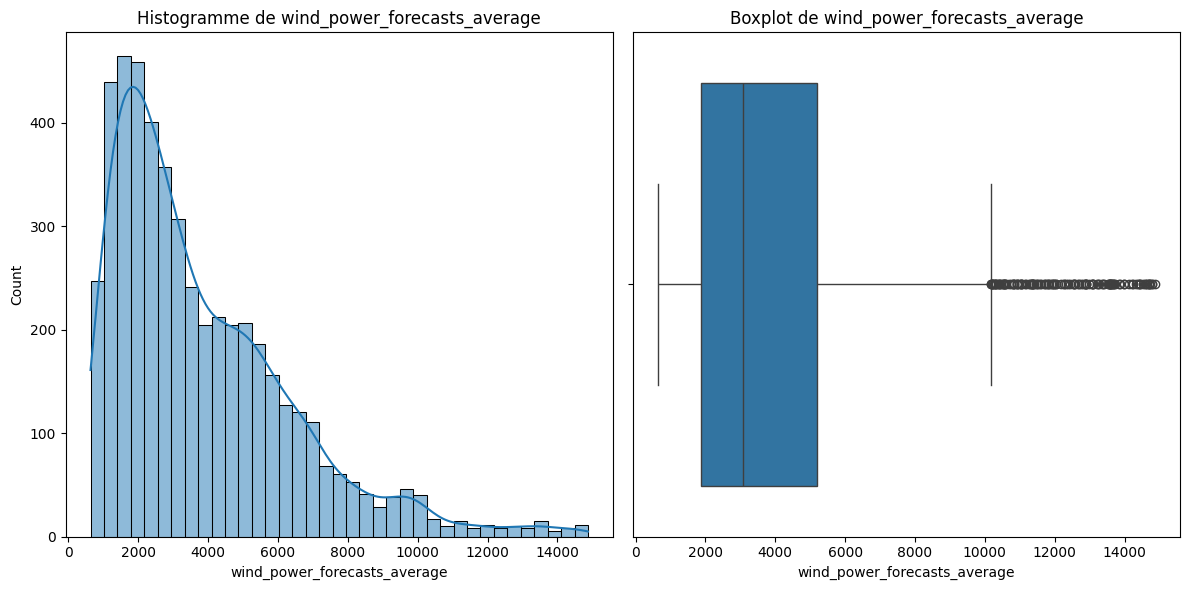

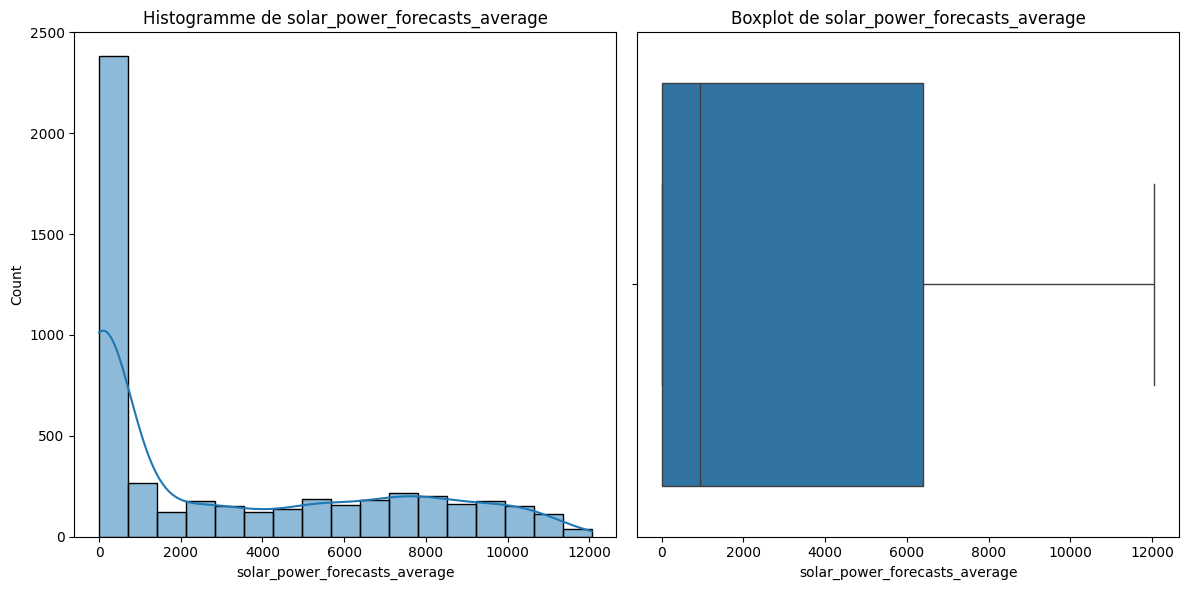

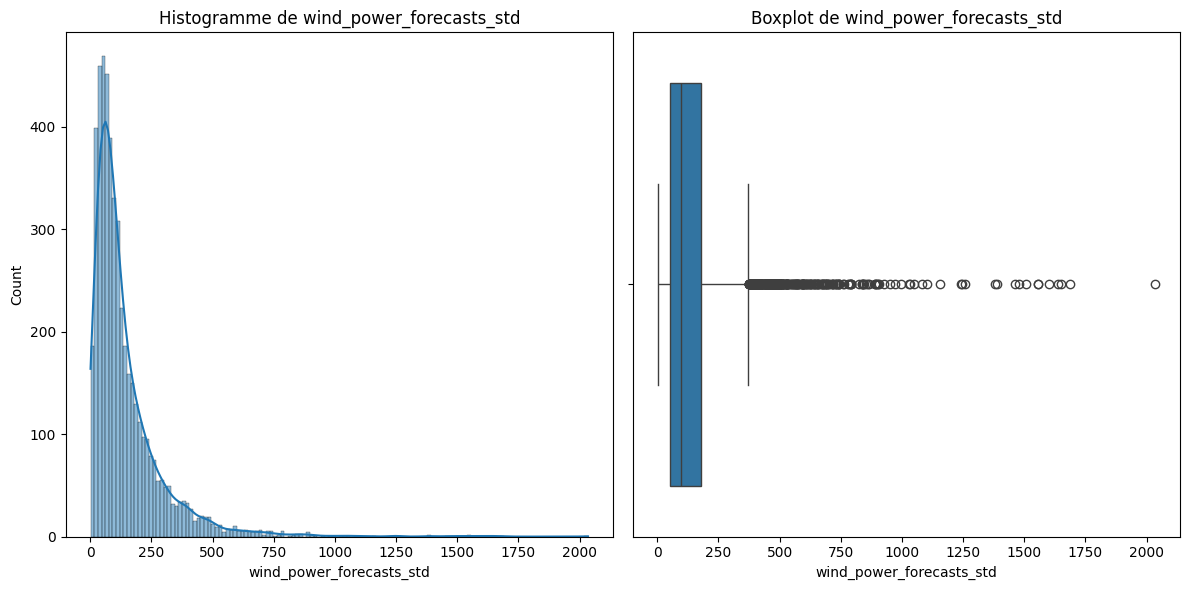

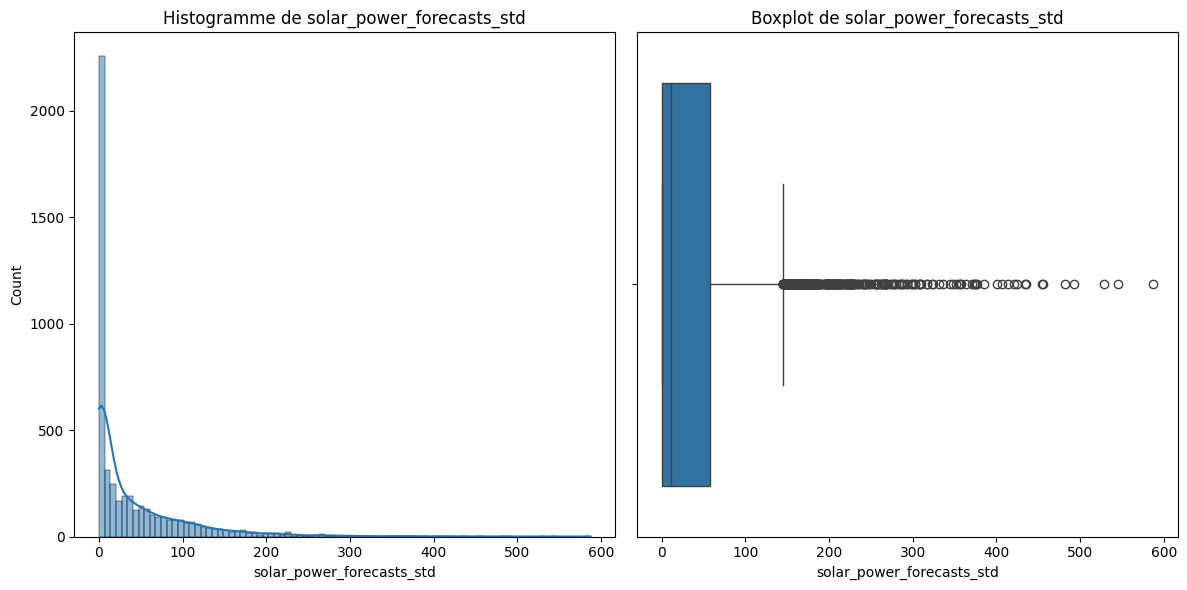

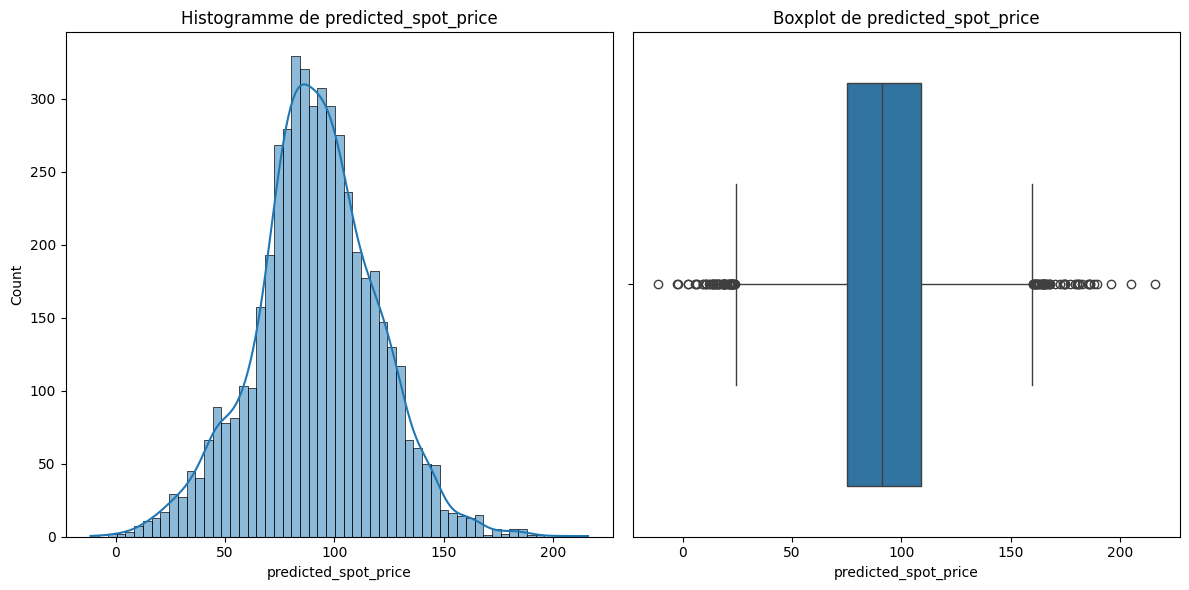

In [82]:
univariate_analysis(x_challenge_new, deviant_columns, [])

In [83]:
# On va maintenant essayer de remplacer les valeurs abérantes observées à l'aide de la dernière cellule 
# par la moyenne de la colonne correspondante. 

x_new = replace_outliers_z1(x_new, 10)
x_challenge_new = replace_outliers_z1(x_challenge_new, 10)

Analyse bivariée

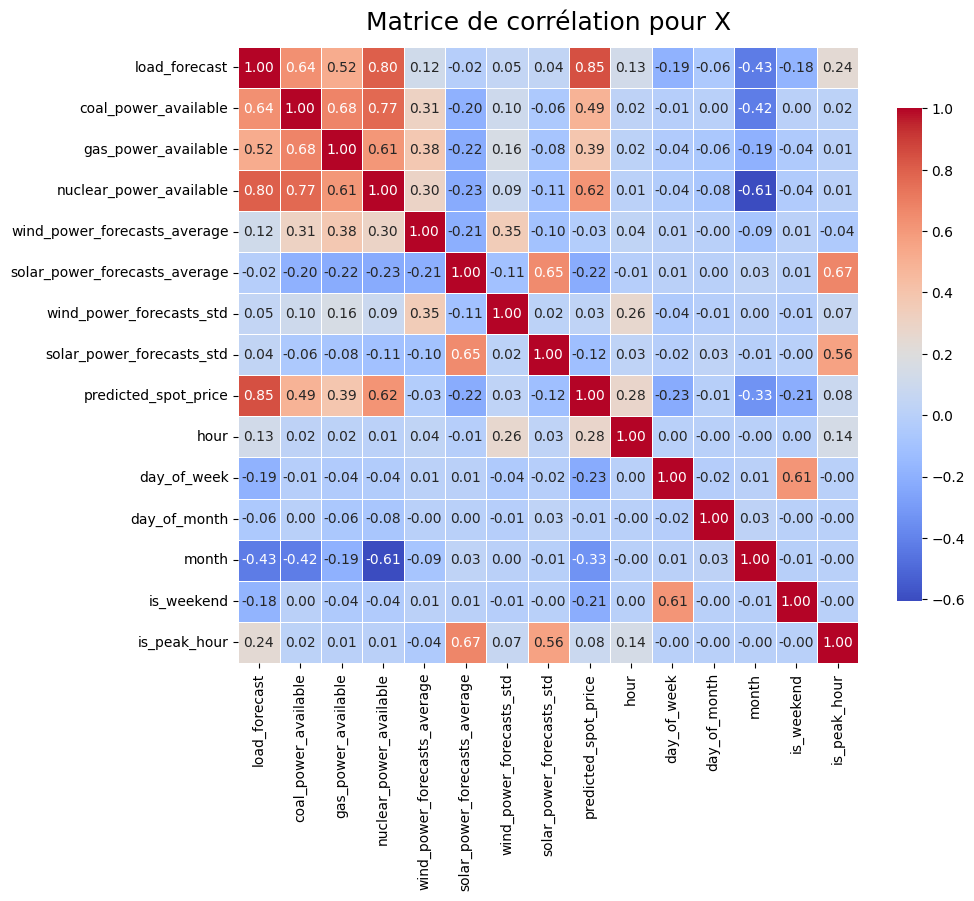

In [84]:
correlation_matrix(x_new.drop(columns=['DELIVERY_START'], axis=1), method='pearson', title='Matrice de corrélation pour X')

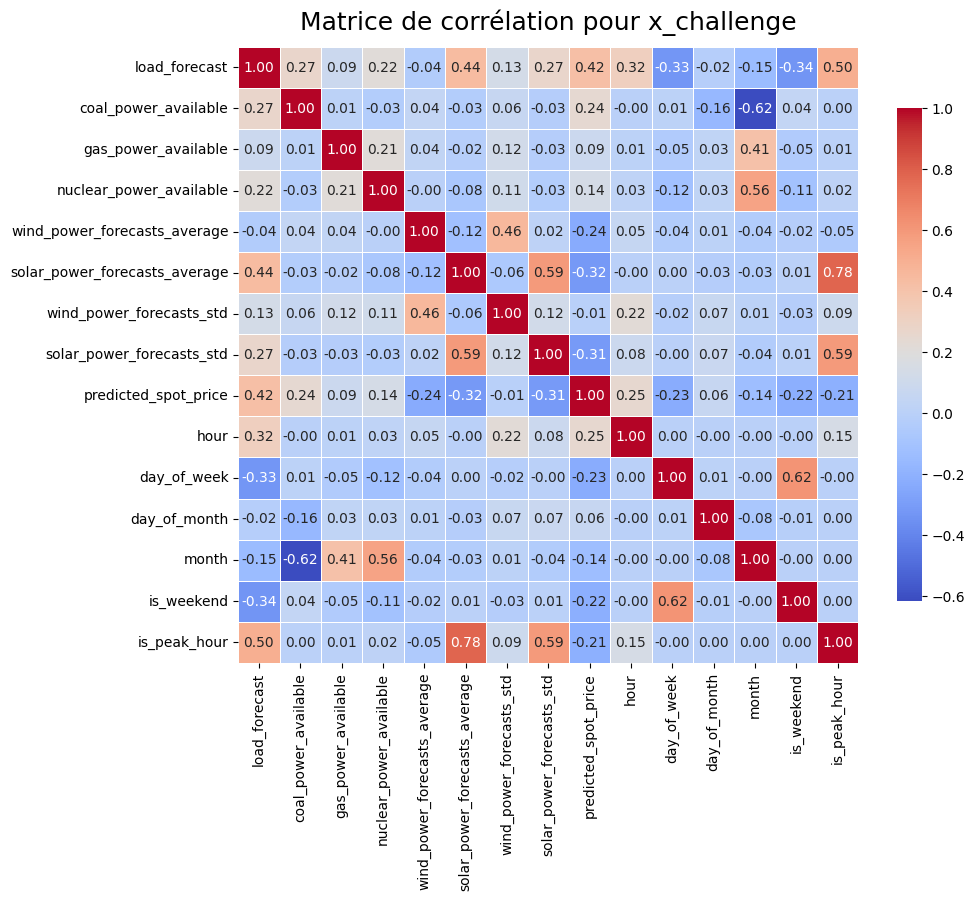

In [85]:
correlation_matrix(x_challenge_new.drop(columns=['DELIVERY_START'], axis=1), 'pearson', 'Matrice de corrélation pour x_challenge')

In [86]:
# En gros si les corrélations sont différentes c'est parce que les données ne sont pas distribuées 
# de la même manière dans les deux jeux de données.

# Je vais commencer par une normalisation des données numériques (faut pas normaliser les truc sur le temps)

Normalisation des données

In [87]:
scaler = StandardScaler()

scaler.fit(x_new[deviant_columns])

x_scaled = x_new.copy()
x_challenge_scaled = x_challenge_new.copy()

x_scaled[deviant_columns] = scaler.transform(x_new[deviant_columns])
x_challenge_scaled[deviant_columns] = scaler.transform(x_challenge_new[deviant_columns])

x_challenge_scaled.head(5)

DELIVERY_START  load_forecast  coal_power_available  \
10605 2023-04-01 22:00:00+00:00      -0.579978              1.143747   
10606 2023-04-01 23:00:00+00:00      -0.732939              1.143747   
10607 2023-04-02 00:00:00+00:00      -0.803938              1.143747   
10608 2023-04-02 01:00:00+00:00      -1.021089              1.143747   
10609 2023-04-02 02:00:00+00:00      -1.166447              1.143747   

       gas_power_available  nuclear_power_available  \
10605            -1.160177                 0.172253   
10606            -1.160177                 0.172253   
10607            -1.160177                 0.172253   
10608            -1.160177                 0.172253   
10609            -1.160177                 0.172253   

       wind_power_forecasts_average  solar_power_forecasts_average  \
10605                      0.544404                      -0.707845   
10606                      0.577123                      -0.707845   
10607                      0.589616                      -0.707845   
10608                      0.624419                      -0.707845   
10609                      0.645835                      -0.707845   

       wind_power_forecasts_std  solar_power_forecasts_std  \
10605                 -0.537069                  -0.595488   
10606                 -0.556829                  -0.595488   
10607                 -0.368555                  -0.595488   
10608                 -0.367911                  -0.595488   
10609                 -0.221218                  -0.595488   

       predicted_spot_price  hour  day_of_week  day_of_month  month  \
10605              0.046976    22            5             1      4   
10606             -0.066747    23            5             1      4   
10607             -0.705739     0            6             2      4   
10608             -0.865295     1            6             2      4   
10609             -0.945523     2            6             2      4   

       is_weekend  is_peak_hour  
10605           0             0  
10606           0             0  
10607           1             0  
10608           1             0  
10609           1             0

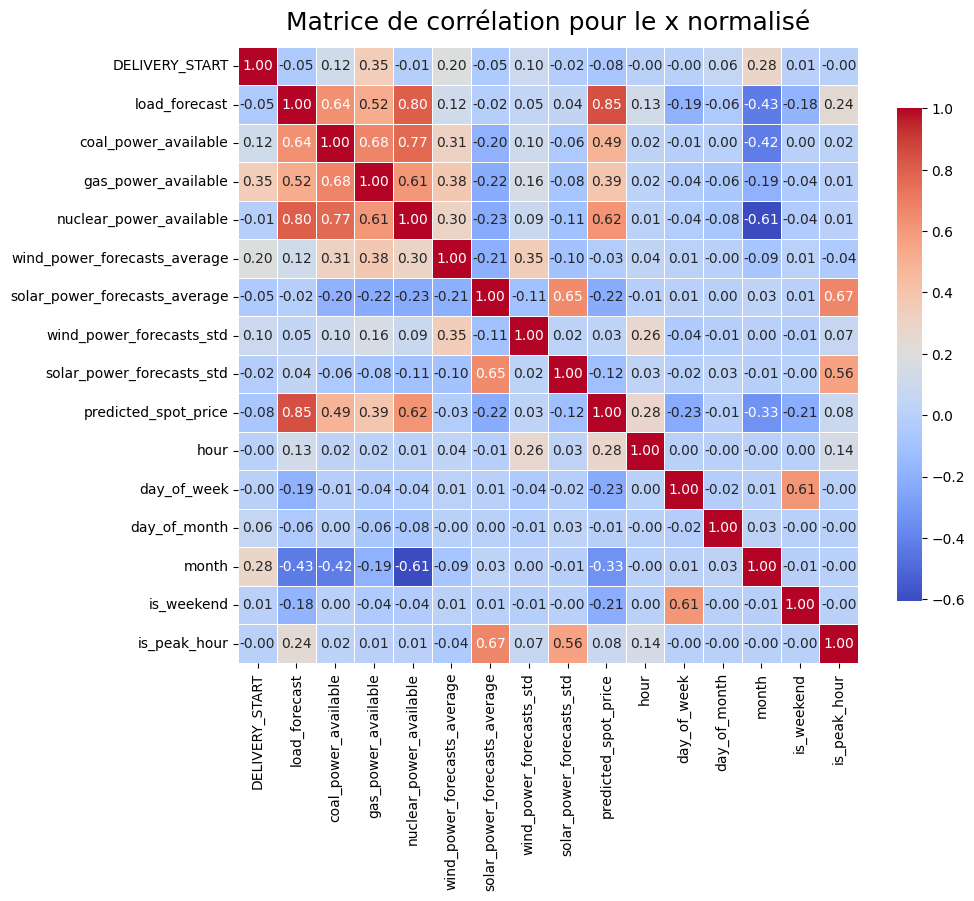

In [88]:
correlation_matrix(x_scaled, 'pearson', 'Matrice de corrélation pour le x normalisé')

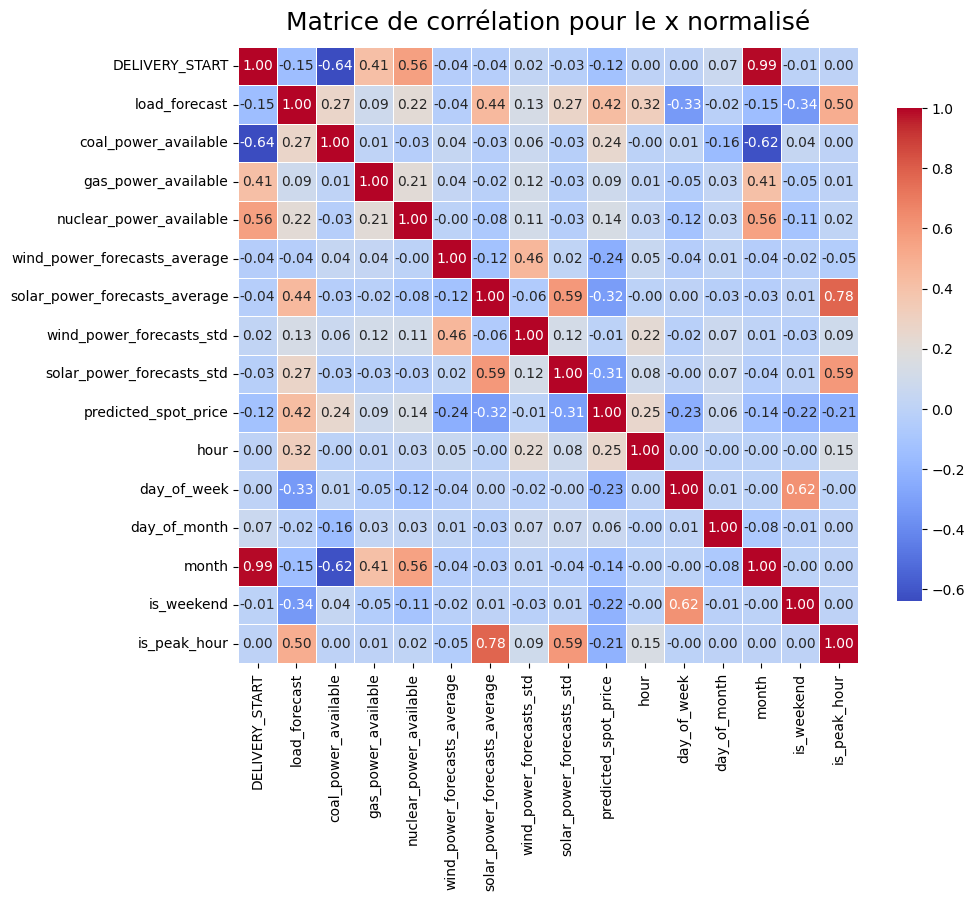

In [89]:
correlation_matrix(x_challenge_scaled, 'pearson', 'Matrice de corrélation pour le x normalisé')

Export des DataFrames

In [90]:
x_scaled.to_csv('../data/processed/x_processed.csv', index=False)
x_challenge_scaled.to_csv('../data/processed/x_challenge_processed.csv', index=False)